In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from scipy import interpolate
import pandas as pd
import csv 
import itertools
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np 
import matplotlib.pyplot as plt
from datetime import timedelta
import datetime
import fbprophet
from matplotlib import pyplot
from pandas import to_datetime
from fbprophet import Prophet
from time_series_generator import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import plotly.graph_objs as go
from sklearn.metrics import f1_score
import math
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
import random

2023-09-04 17:14:02.763657: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 17:14:02.785000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-04 17:14:02.785468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-04 17:14:03.285118: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df_for=pd.read_csv("6_df_interpolated_for_forecasting_aug10.csv")
#df_for=df_for.drop(["Unnamed: 0"],axis=1)
df_for

,Unnamed: 0,Date,Area,Gender,Race,Ethinicity,Wound
0,0,2016-10-26,4.0000,M,White,Non-Hispanic,1
1,1,2016-10-27,4.0000,M,White,Non-Hispanic,1
2,2,2016-10-28,4.0000,M,White,Non-Hispanic,1
3,3,2016-10-29,4.0000,M,White,Non-Hispanic,1
4,4,2016-10-30,4.0000,M,White,Non-Hispanic,1
...,...,...,...,...,...,...,...
1290115,1290115,2023-01-05,2.7064,F,White,Non-Hispanic,17884
1290116,1290116,2023-01-06,2.7064,F,White,Non-Hispanic,17884
1290117,1290117,2023-01-07,2.7064,F,White,Non-Hispanic,17884
1290118,1290118,2023-01-08,2.7064,F,White,Non-Hispanic,17884


In [39]:
def model_LSTM(df):
    # Load and preprocess your DataFrame
    data = df  # Load your DataFrame
    data['Date'] = pd.to_datetime(data['Date'])  # Convert 'Date' column to datetime
    dataframe=df.copy()
    
    # Normalize the 'Area' values
    scaler = MinMaxScaler()
    data['Area'] = scaler.fit_transform(data['Area'].values.reshape(-1, 1))

    # Create sequences and target values
    sequence_length = 1  # Adjust as needed
    sequences = []
    target_values = []

    random_number_start=random.randint(0,data.shape[0]-int(0.20*data.shape[0]))
    random_number_end=random_number_start+int(0.20*data.shape[0])

    data_test=data[random_number_start:random_number_end]
    remove_index=list(data_test.index.values)
    data_train=data.drop(remove_index,axis=0)

    # Make train dataset
    for i in range(len(data_train) - sequence_length):
        sequences.append(data_train['Area'].values[i:i+sequence_length])
        target_values.append(data_train['Area'].values[i+sequence_length])

    X_train = np.array(sequences)
    y_train = np.array(target_values)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

    # Make test dataset
    sequences = []
    target_values = []
    for i in range(len(data_test) - sequence_length):
        sequences.append(data_test['Area'].values[i:i+sequence_length])
        target_values.append(data_test['Area'].values[i+sequence_length])

    X_test = np.array(sequences)
    y_test = np.array(target_values)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    #units=int(df.shape[0])
    
    
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
    
#     if df.shape[0]<40:
#         model.add(LSTM(50, activation='relu', return_sequences=True))
#         model.add(LSTM(50, activation='relu', return_sequences=True))
#         model.add(LSTM(50, activation='relu', return_sequences=True))
#         print("Number of total LSTM Blocks:",5)
    
#     else:
#         for k in range(0, int(df.shape[0]/20)-2):
#             model.add(LSTM(50, activation='relu', return_sequences=True))
#         print("Number of total LSTM Blocks:",k+3)

    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse',metrics=tf.metrics.MeanAbsoluteError())

    print("Total number of visit days after interpolation",df.shape[0])
    # Train the model on the training data
    model.fit(X_train, y_train, epochs=50, batch_size=16,verbose=0)

    # Make predictions on the entire dataset
    predicted_values_test = model.predict(X_test)
    predicted_values_train = model.predict(X_train)

    # Inverse transform predictions and target values
    predicted_values_test = scaler.inverse_transform(predicted_values_test)
    predicted_values_train = scaler.inverse_transform(predicted_values_train)
    y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()
    y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Create arrays for plotting the entire time series
    train_dates = data_train['Date'].iloc[:-sequence_length]
    test_dates = data_test['Date'].iloc[:-sequence_length]
    all_dates=dataframe['Date'].iloc[:-sequence_length]
    all_values=dataframe['Area'].iloc[:-sequence_length]
    
    #appended_series_date = train_dates.append(test_dates, ignore_index=True)
    #appended_series_area = y_train_original.append(y_test_original, ignore_index=True)


    # Plot the entire time series data: train, test, and predicted values
    plt.figure(figsize=(12, 6))
    #plt.plot(train_dates, y_train_original, label='Train Actual')
    #plt.plot(test_dates, y_test_original, label='Test Actual')
    plt.plot(all_dates,all_values,label='Original')
    plt.plot(test_dates, predicted_values_test, label='Forecasted by LSTM')
    plt.xlabel('Date')
    plt.ylabel('Area Value')
    #plt.title('Time Series Forecasting with LSTM')
    plt.legend()
    plt.grid(True)
    plt.show()


    actual=y_test_original
    forecast=predicted_values_test
    
#     print(actual)
#     print(forecast.flatten())

    corr= np.corrcoef(actual,forecast.flatten())[0,1]
    r_square= corr**2  #r_square

    #print("R-square:",r_square)

    y_hat_avg = pd.DataFrame(y_test).copy()
    y_hat_avg['LSTM']=pd.DataFrame(forecast)[0].values


    training_series=pd.DataFrame(y_train)[0]
    testing_series=pd.DataFrame(y_test)[0]
    prediction_series= y_hat_avg.LSTM

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    #r_square=r2_score(pd.DataFrame(actual)[0].tolist(),pd.DataFrame(forecast)[0].tolist())

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    errors = np.abs(testing_series - prediction_series )
    mase=errors.mean()/d
    
    return (rmse, mase, r_square)


## Run for all the wounds

Wound: 1
Total number of visit days after interpolation 133
4/4 [==============================] - 0s 789us/step


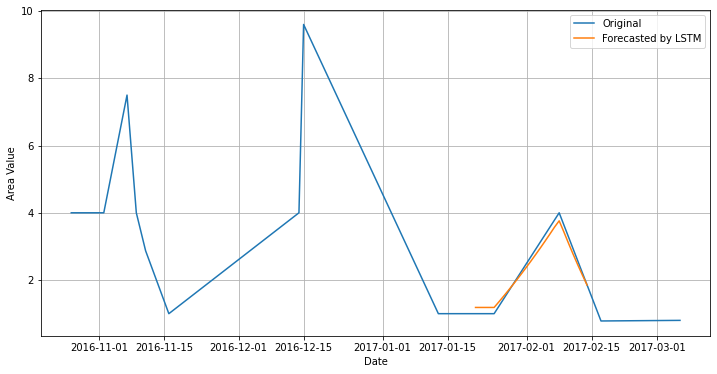

R square: 0.9334 

Wound: 2
Total number of visit days after interpolation 85
3/3 [==============================] - 0s 903us/step


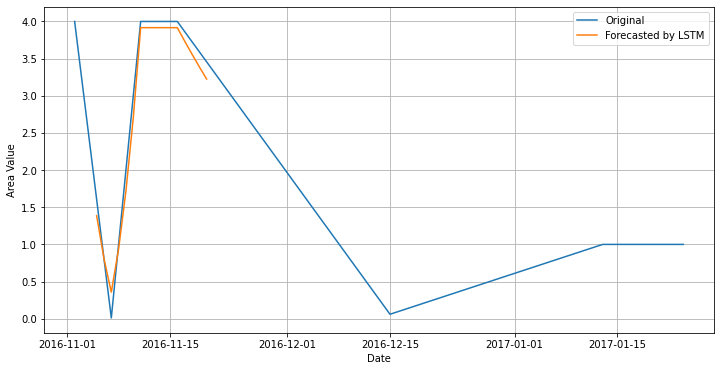

R square: 0.8144 

Wound: 3
Total number of visit days after interpolation 13
1/1 [==============================] - 0s 9ms/step


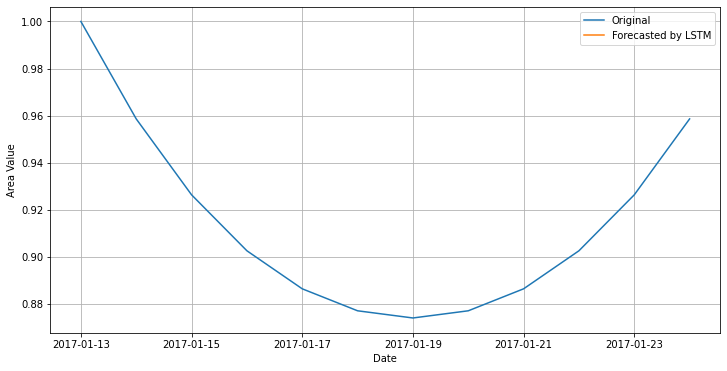

R square: nan 

Wound: 4
Total number of visit days after interpolation 16
1/1 [==============================] - 0s 9ms/step


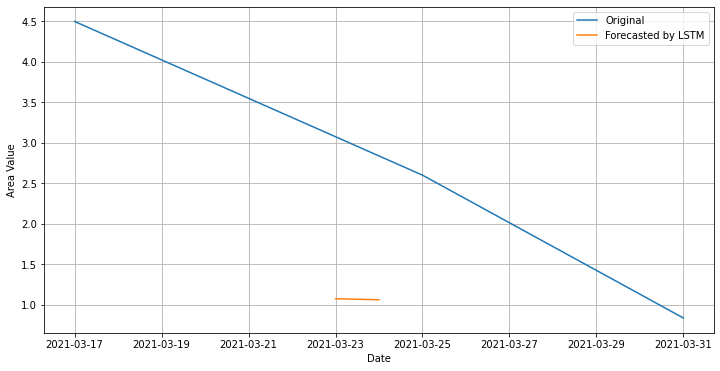

R square: 1.0 

Wound: 5
Total number of visit days after interpolation 16
1/1 [==============================] - 0s 9ms/step


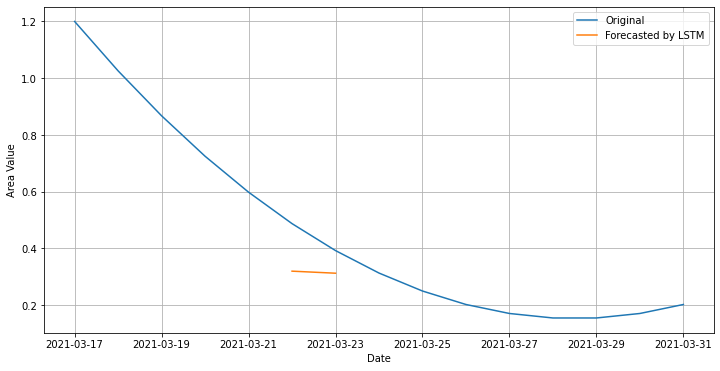

R square: 1.0 

Wound: 6
Total number of visit days after interpolation 344
9/9 [==============================] - 0s 662us/step


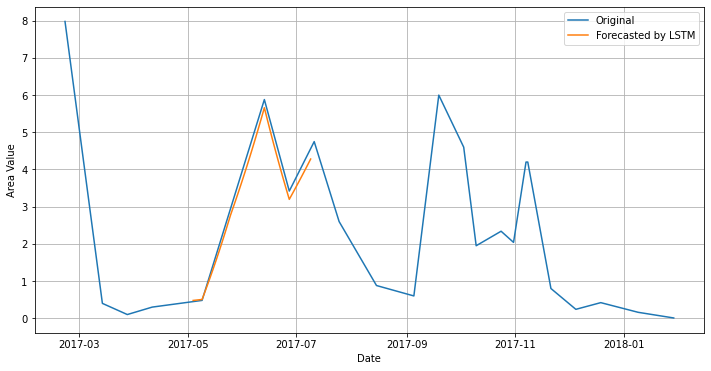

R square: 0.992 

Wound: 7
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


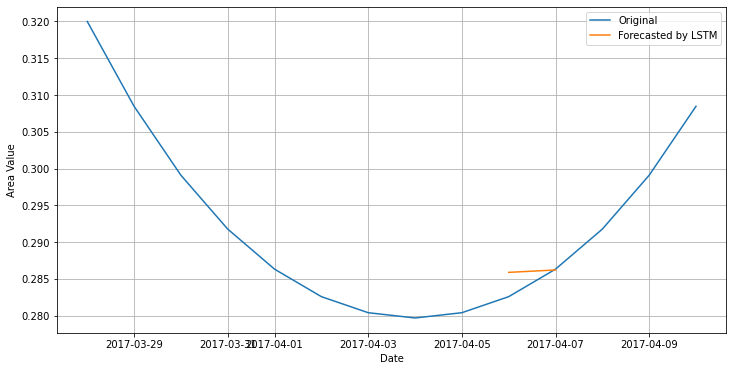

R square: 1.0 

Wound: 8
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


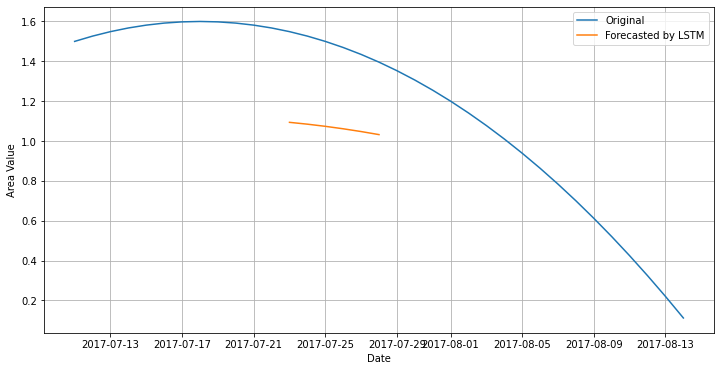

R square: 1.0 

Wound: 9
Total number of visit days after interpolation 253
7/7 [==============================] - 0s 801us/step


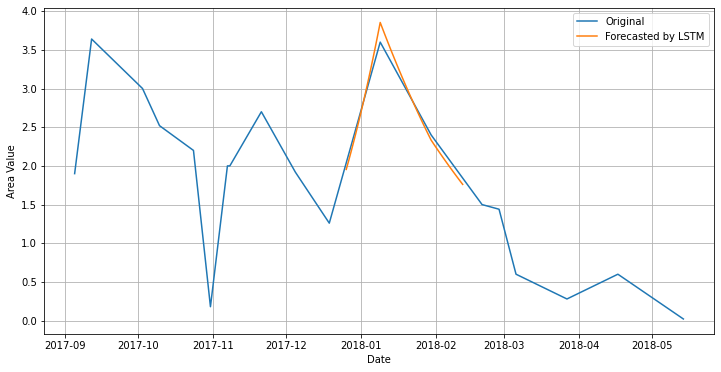

R square: 0.975 

Wound: 10
Total number of visit days after interpolation 148
4/4 [==============================] - 0s 1ms/step


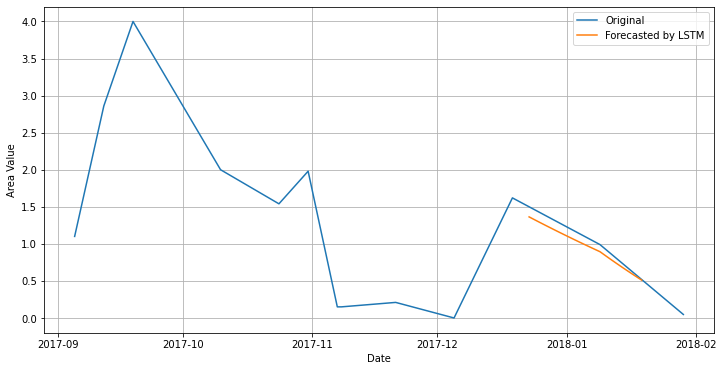

R square: 0.9985 

Wound: 11
Total number of visit days after interpolation 43
2/2 [==============================] - 0s 1ms/step


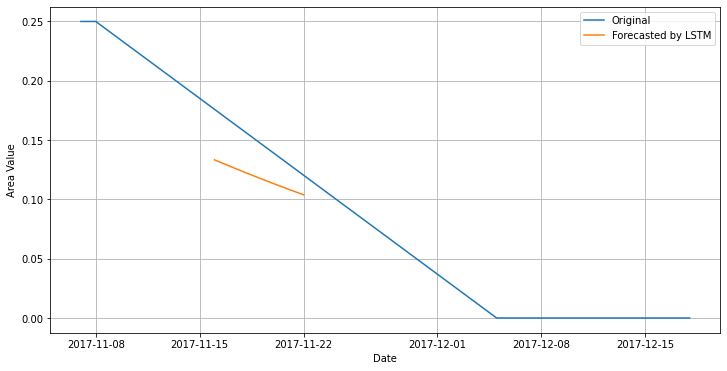

R square: 0.9995 

Wound: 12
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


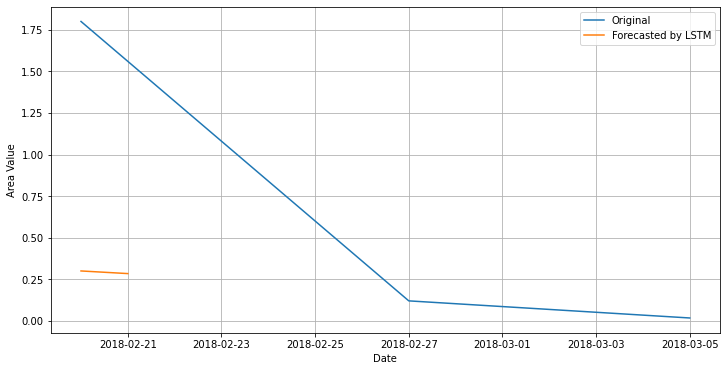

R square: 1.0 

Wound: 13
Total number of visit days after interpolation 533
14/14 [==============================] - 0s 907us/step


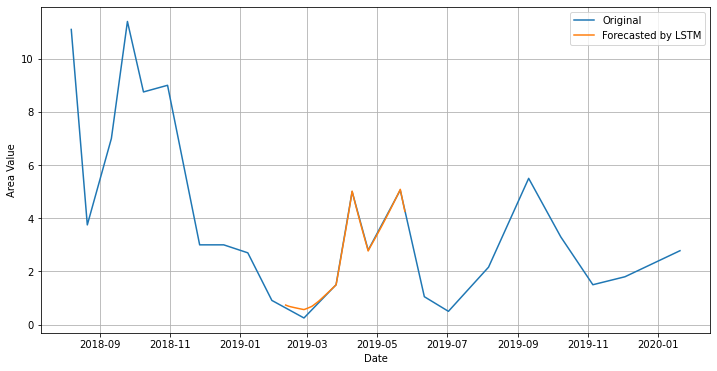

R square: 0.9913 

Wound: 14
Total number of visit days after interpolation 85
3/3 [==============================] - 0s 1ms/step


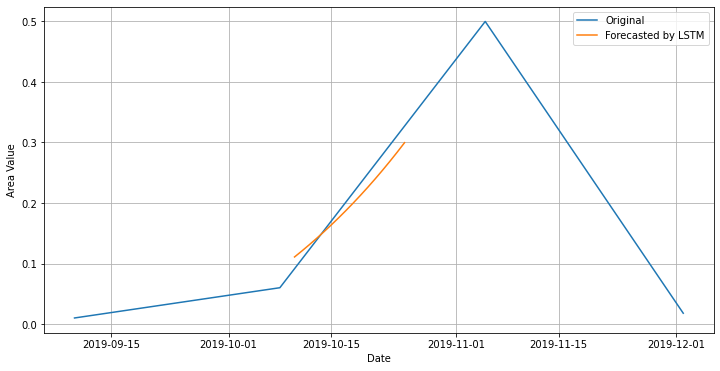

R square: 0.9954 

Wound: 15
Total number of visit days after interpolation 263
7/7 [==============================] - 0s 994us/step


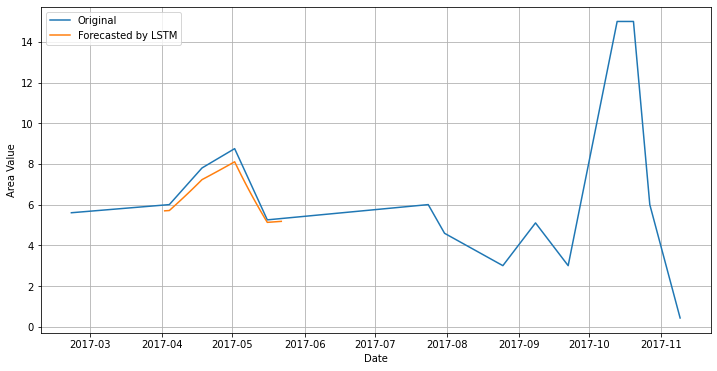

R square: 0.9809 

Wound: 16
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


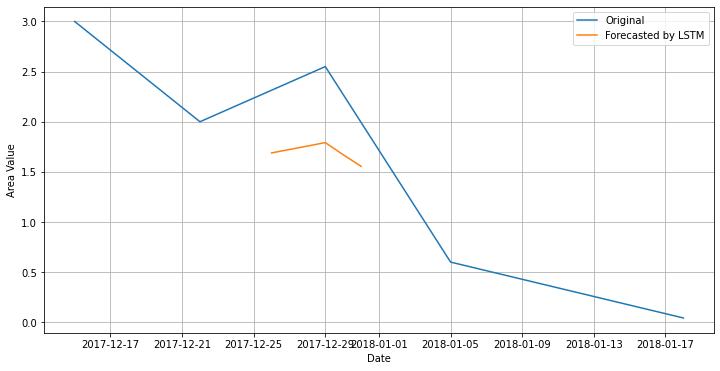

R square: 0.6617 

Wound: 17
Total number of visit days after interpolation 75
2/2 [==============================] - 0s 1ms/step


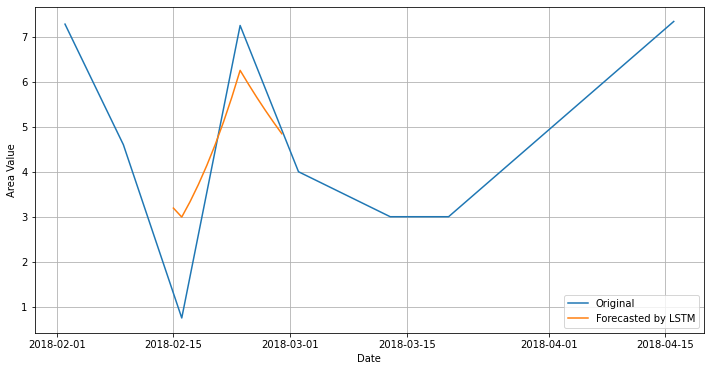

R square: 0.8642 

Wound: 18
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


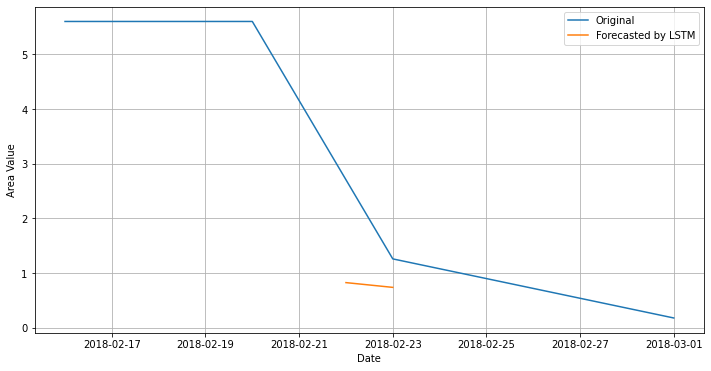

R square: 1.0 

Wound: 19
Total number of visit days after interpolation 57
2/2 [==============================] - 0s 1ms/step


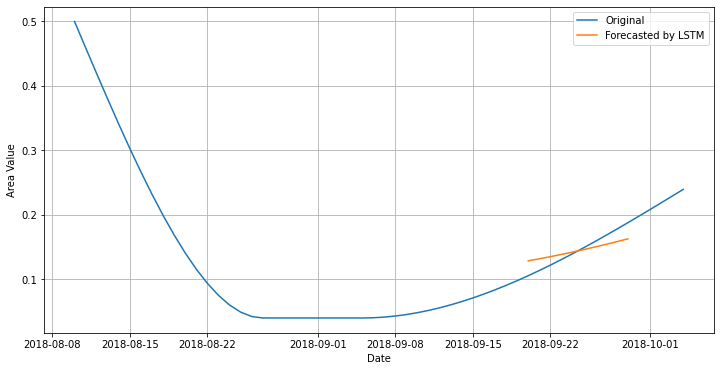

R square: 0.9995 

Wound: 20
Total number of visit days after interpolation 316
8/8 [==============================] - 0s 1ms/step


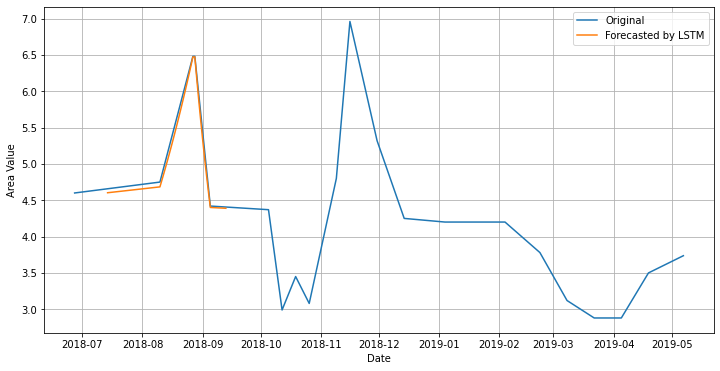

R square: 0.9662 

Wound: 21
Total number of visit days after interpolation 115
3/3 [==============================] - 0s 843us/step


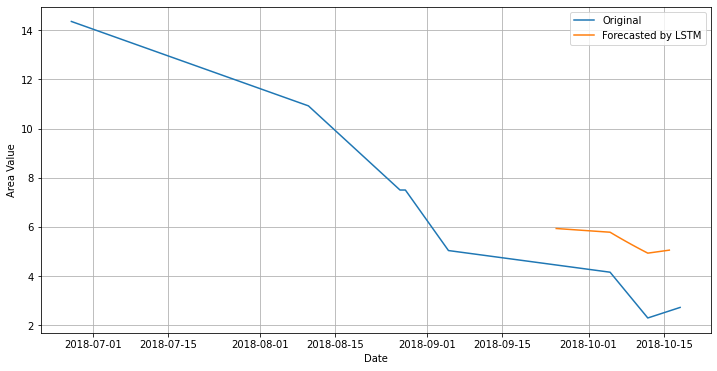

R square: 0.9782 

Wound: 22
Total number of visit days after interpolation 57
2/2 [==============================] - 0s 1ms/step


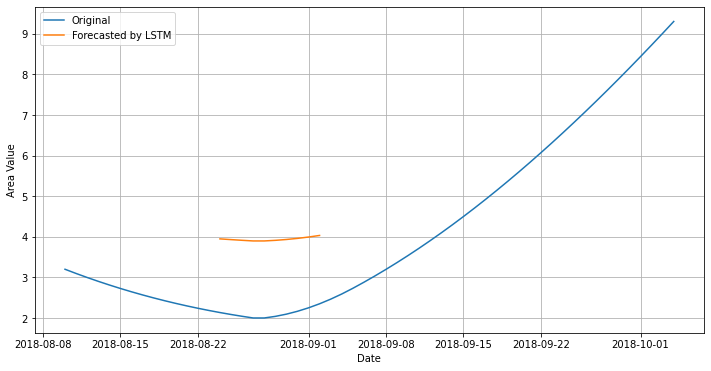

R square: 0.8999 

Wound: 23
Total number of visit days after interpolation 57
2/2 [==============================] - 0s 1ms/step


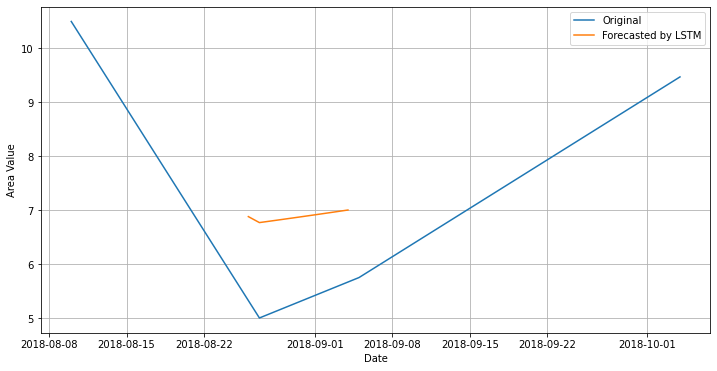

R square: 0.7433 

Wound: 24
Total number of visit days after interpolation 141
4/4 [==============================] - 0s 1ms/step


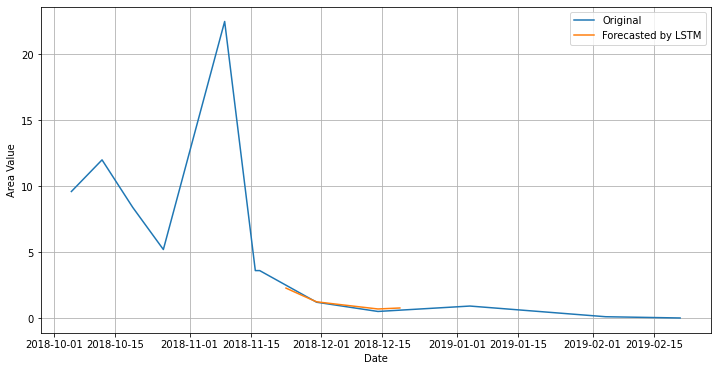

R square: 0.9966 

Wound: 25
Total number of visit days after interpolation 181
5/5 [==============================] - 0s 1ms/step


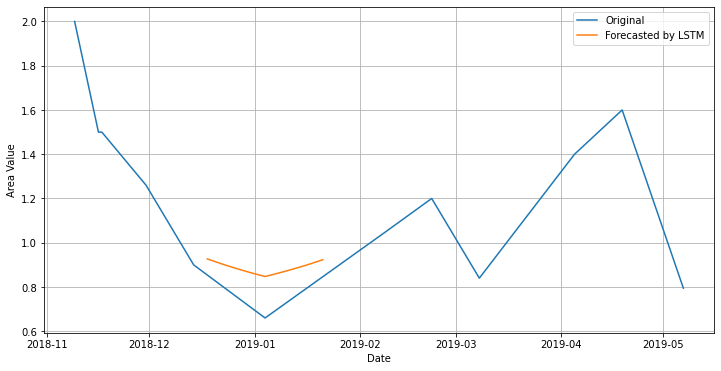

R square: 0.9598 

Wound: 26
Total number of visit days after interpolation 477
12/12 [==============================] - 0s 925us/step


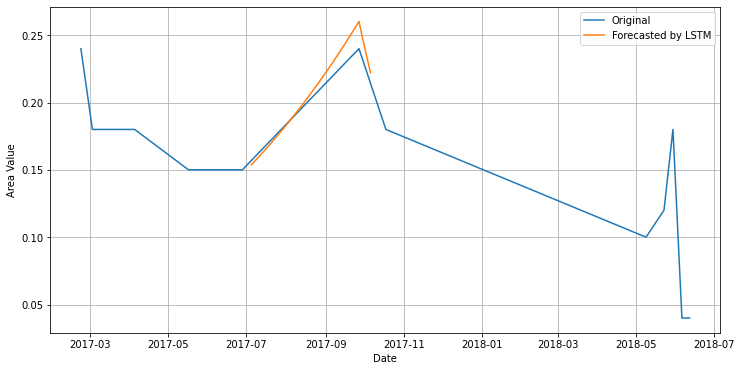

R square: 0.9939 

Wound: 27
Total number of visit days after interpolation 181
5/5 [==============================] - 0s 1ms/step


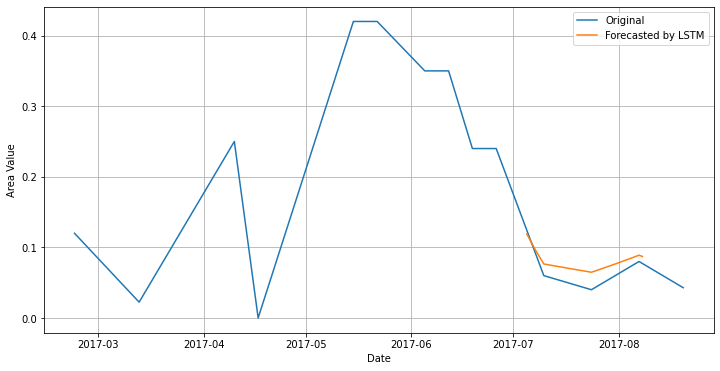

R square: 0.9406 

Wound: 28
Total number of visit days after interpolation 85
3/3 [==============================] - 0s 1ms/step


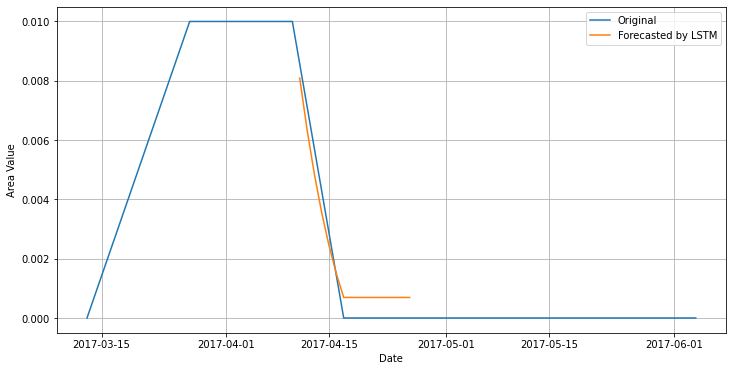

R square: 0.9913 

Wound: 29
Total number of visit days after interpolation 43
2/2 [==============================] - 0s 1ms/step


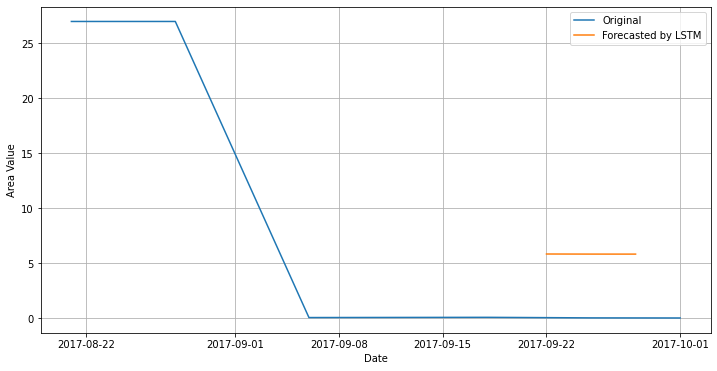

R square: 0.9647 

Wound: 30
Total number of visit days after interpolation 71
2/2 [==============================] - 0s 1ms/step


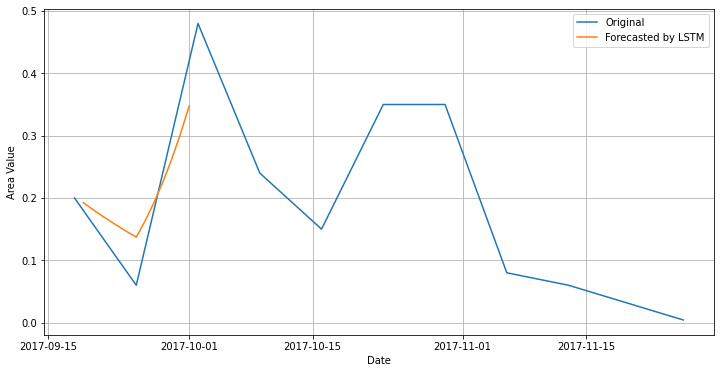

R square: 0.9288 

Wound: 31
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


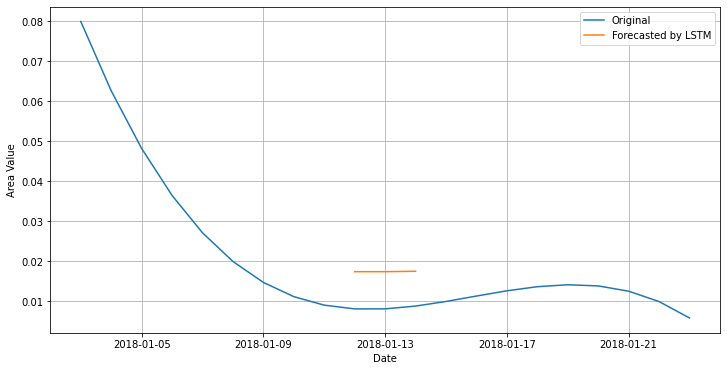

R square: 0.864 

Wound: 32
Total number of visit days after interpolation 155
4/4 [==============================] - 0s 1ms/step


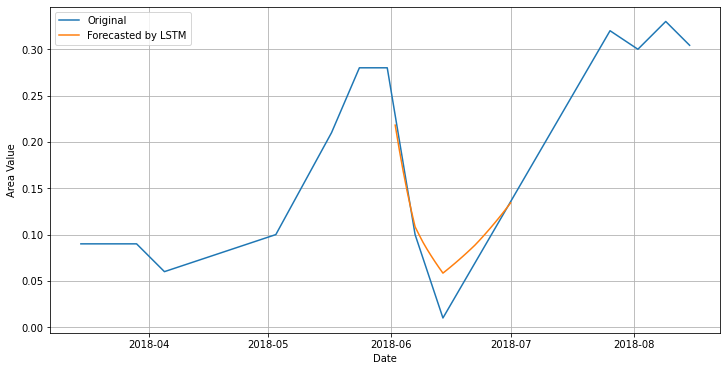

R square: 0.9114 

Wound: 33
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


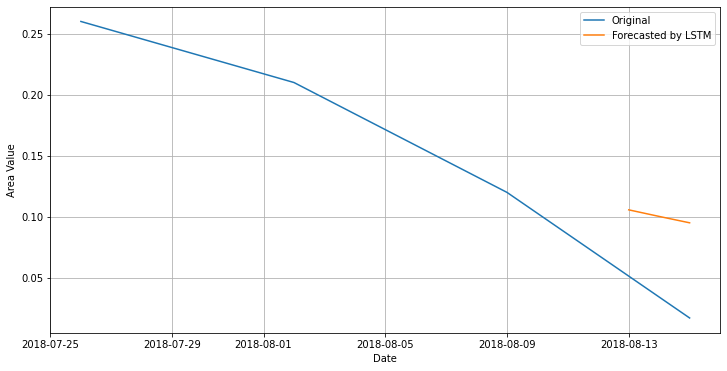

R square: 0.9999 

Wound: 34
Total number of visit days after interpolation 490
13/13 [==============================] - 0s 851us/step


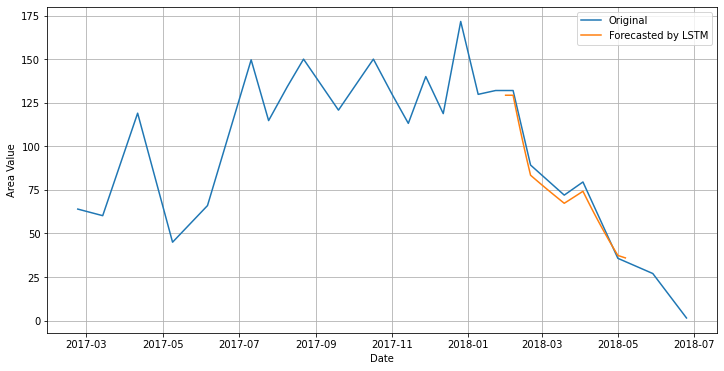

R square: 0.9916 

Wound: 35
Total number of visit days after interpolation 113
3/3 [==============================] - 0s 906us/step


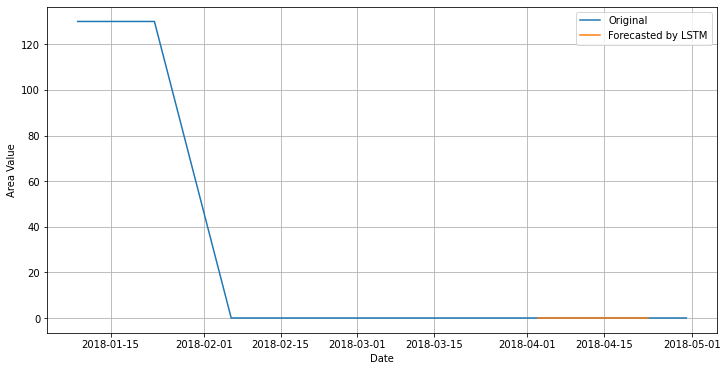

R square: nan 

Wound: 36
Total number of visit days after interpolation 29
1/1 [==============================] - 0s 9ms/step


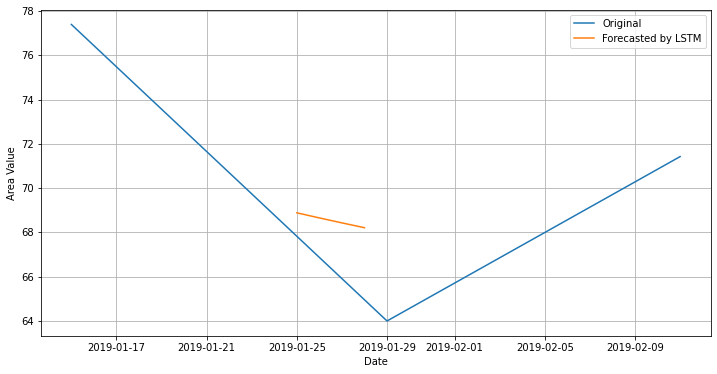

R square: 0.9998 

Wound: 37
Total number of visit days after interpolation 164
5/5 [==============================] - 0s 1ms/step


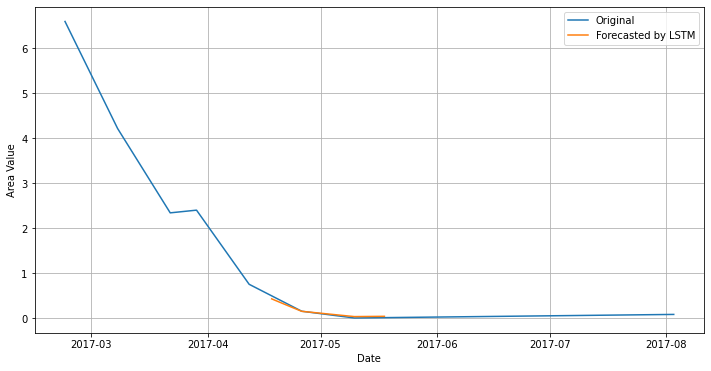

R square: 0.9976 

Wound: 38
Total number of visit days after interpolation 120
3/3 [==============================] - 0s 903us/step


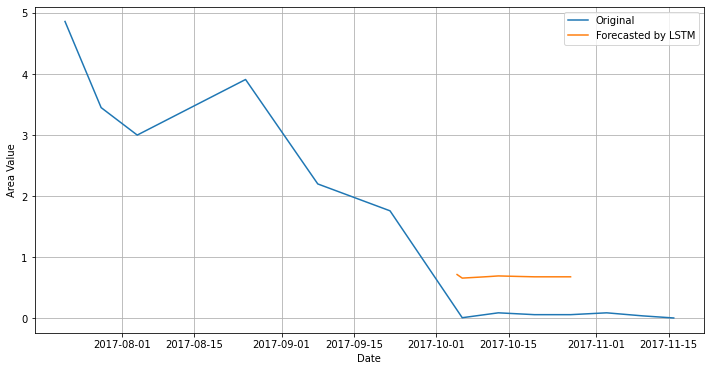

R square: 0.0325 

Wound: 39
Total number of visit days after interpolation 148
4/4 [==============================] - 0s 851us/step


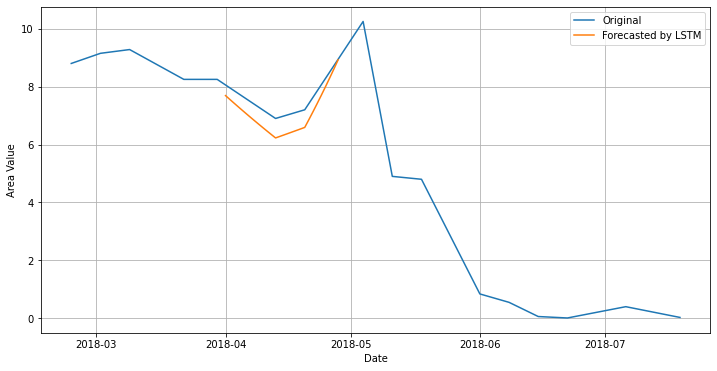

R square: 0.9635 

Wound: 40
Total number of visit days after interpolation 43
2/2 [==============================] - 0s 1ms/step


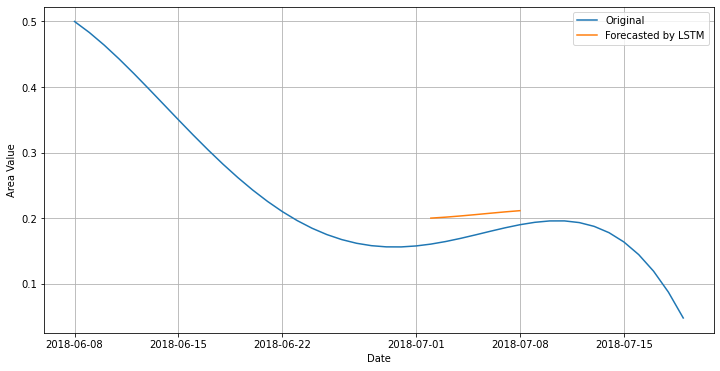

R square: 0.9951 

Wound: 41
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


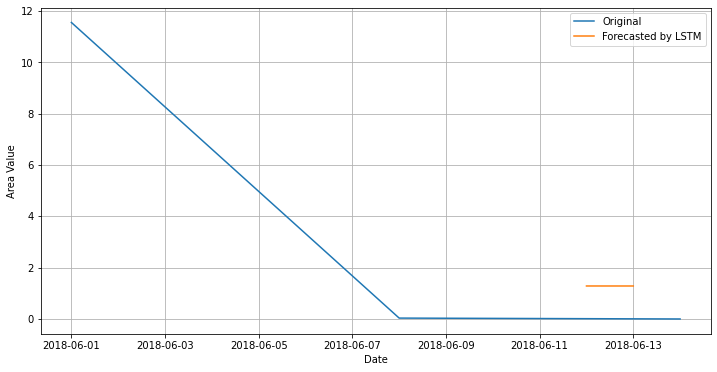

R square: 1.0 

Wound: 42
Total number of visit days after interpolation 48
2/2 [==============================] - 0s 1ms/step


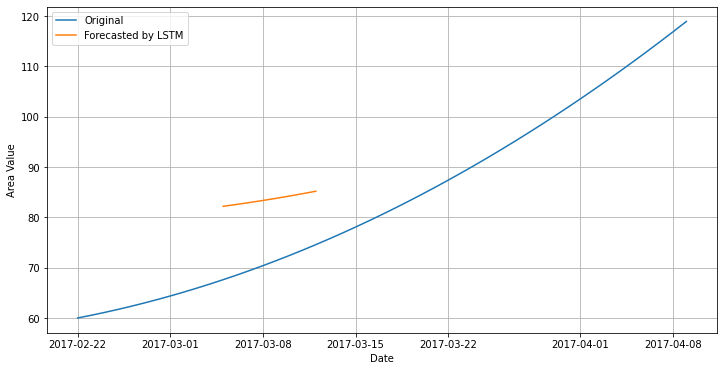

R square: 0.9998 

Wound: 43
Total number of visit days after interpolation 59
2/2 [==============================] - 0s 1ms/step


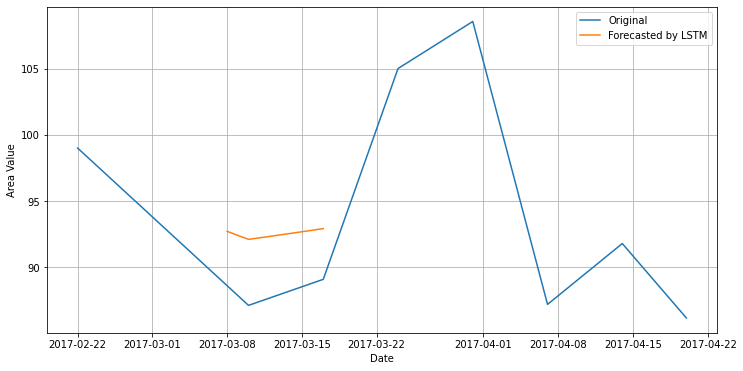

R square: 0.6046 

Wound: 44
Total number of visit days after interpolation 64
2/2 [==============================] - 0s 2ms/step


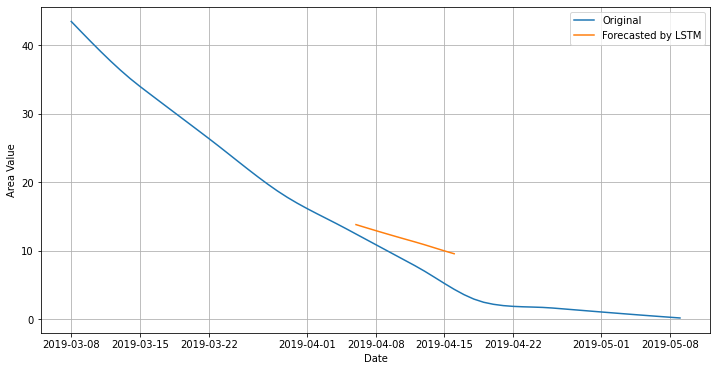

R square: 0.9993 

Wound: 45
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


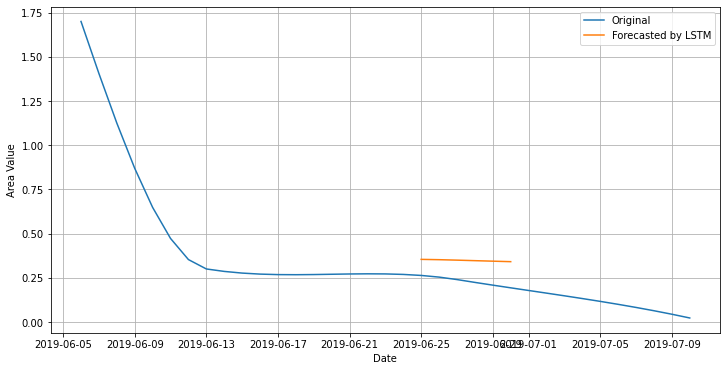

R square: 0.9959 

Wound: 46
Total number of visit days after interpolation 49
2/2 [==============================] - 0s 1ms/step


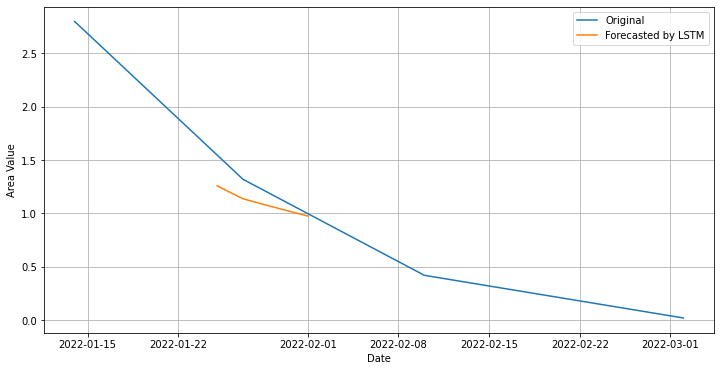

R square: 0.9914 

Wound: 47
Total number of visit days after interpolation 76
2/2 [==============================] - 0s 2ms/step


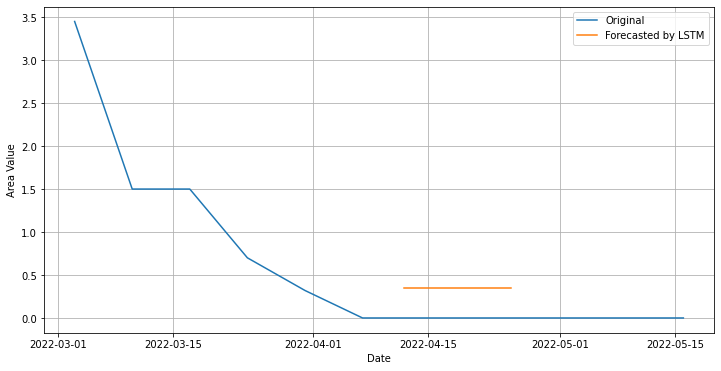

R square: nan 

Wound: 48
Total number of visit days after interpolation 113
3/3 [==============================] - 0s 1ms/step


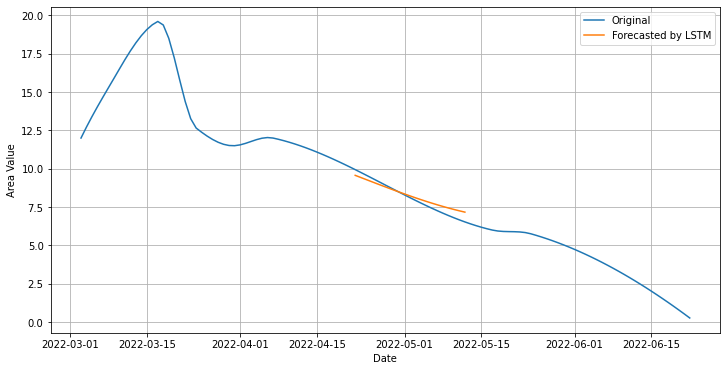

R square: 0.9998 

Wound: 49
Total number of visit days after interpolation 106
3/3 [==============================] - 0s 932us/step


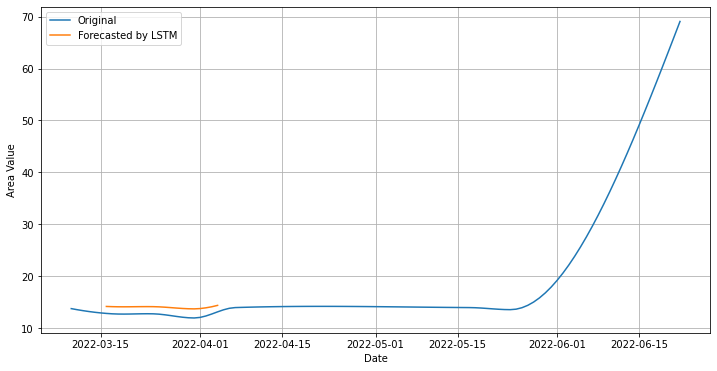

R square: 0.794 

Wound: 50
Total number of visit days after interpolation 50
2/2 [==============================] - 0s 1ms/step


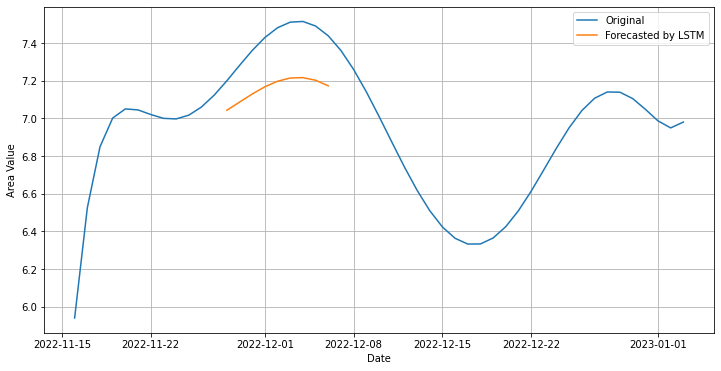

R square: 0.7277 

Wound: 51
Total number of visit days after interpolation 57
2/2 [==============================] - 0s 1ms/step


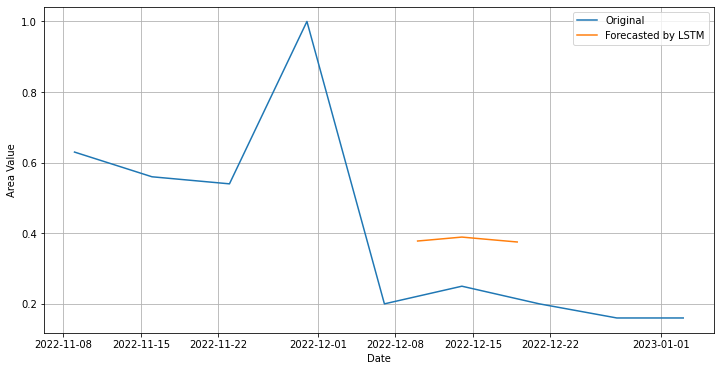

R square: 0.6992 

Wound: 52
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


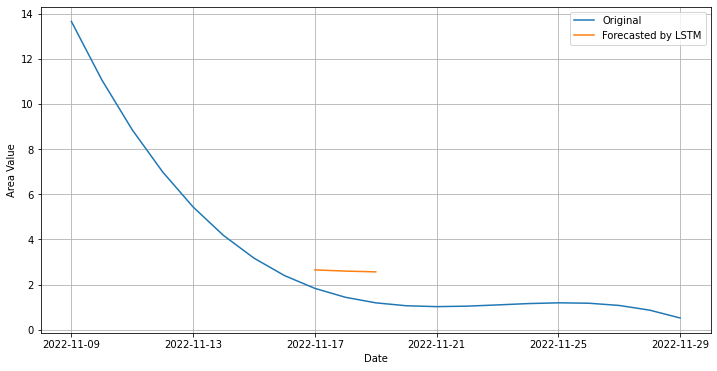

R square: 0.9979 

Wound: 53
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


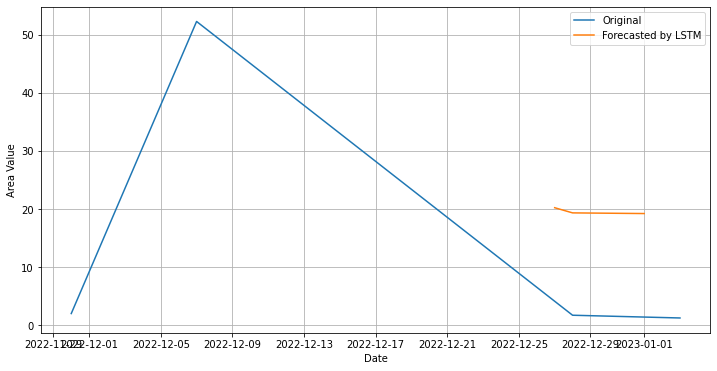

R square: 0.5328 

Wound: 54
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


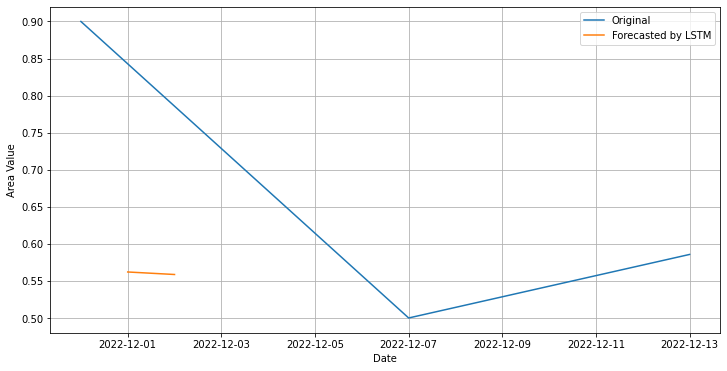

R square: 1.0 

Wound: 55
Total number of visit days after interpolation 1329
34/34 [==============================] - 0s 726us/step


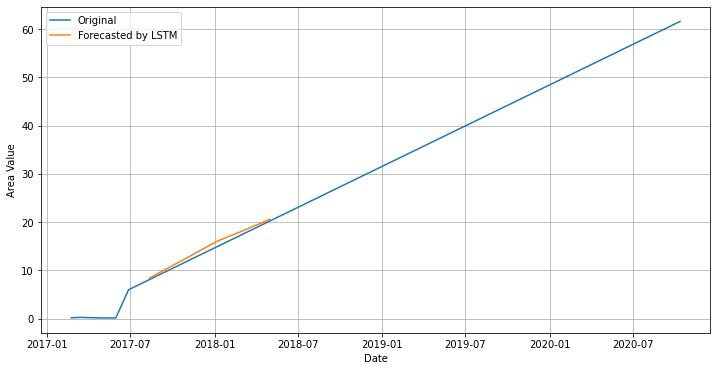

R square: 0.9958 

Wound: 56
Total number of visit days after interpolation 154
4/4 [==============================] - 0s 1ms/step


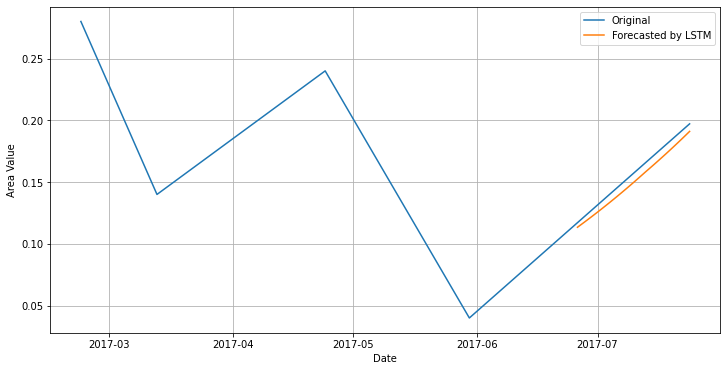

R square: 0.9988 

Wound: 57
Total number of visit days after interpolation 62
2/2 [==============================] - 0s 2ms/step


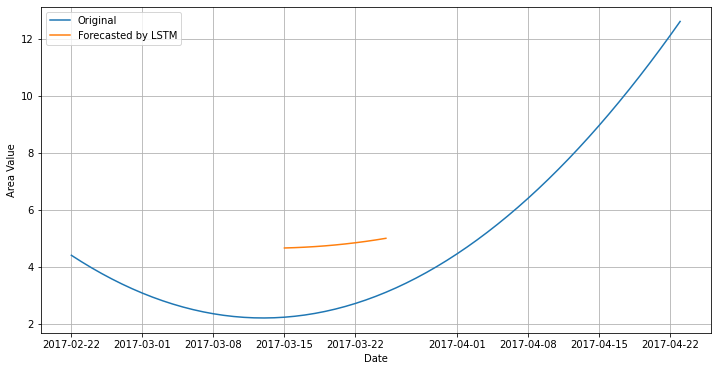

R square: 0.9986 

Wound: 58
Total number of visit days after interpolation 154
4/4 [==============================] - 0s 807us/step


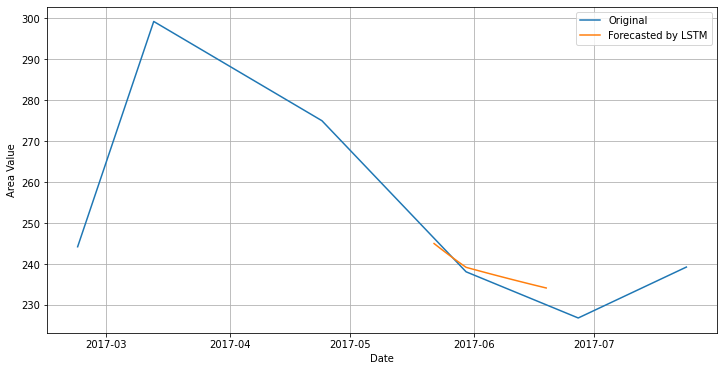

R square: 0.9967 

Wound: 59
Total number of visit days after interpolation 135
4/4 [==============================] - 0s 1ms/step


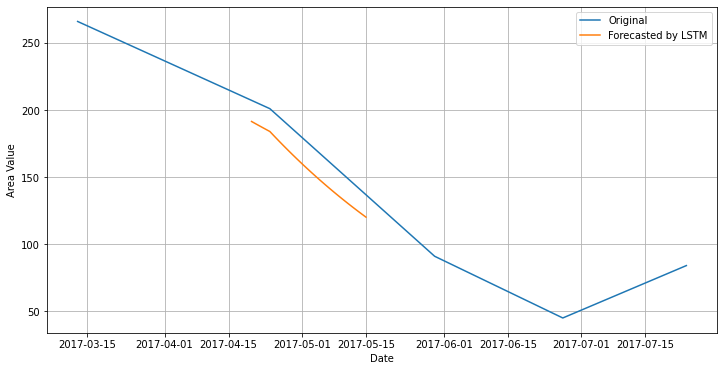

R square: 0.9982 

Wound: 60
Total number of visit days after interpolation 135
4/4 [==============================] - 0s 772us/step


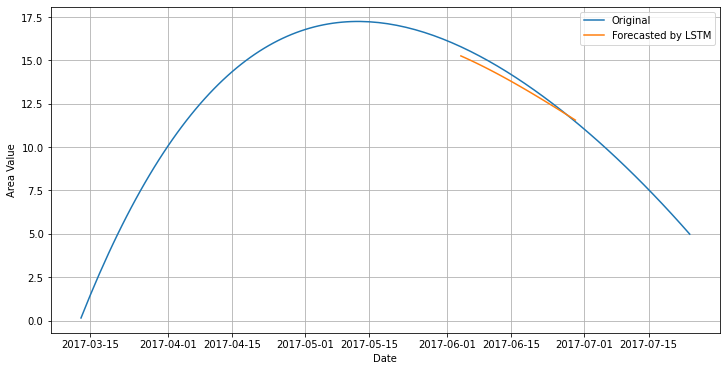

R square: 0.9993 

Wound: 61
Total number of visit days after interpolation 1310
33/33 [==============================] - 0s 838us/step


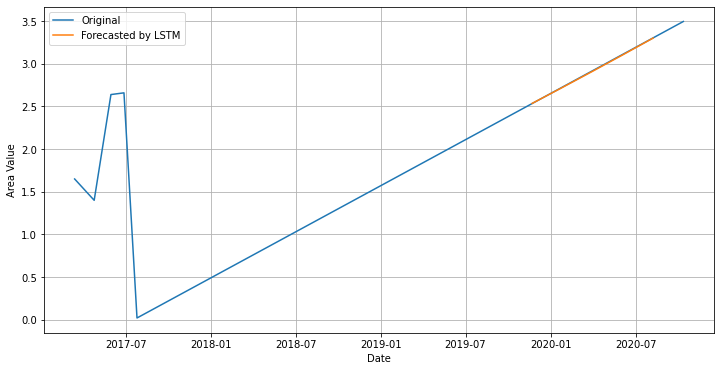

R square: 0.9999 

Wound: 62
Total number of visit days after interpolation 135
4/4 [==============================] - 0s 1ms/step


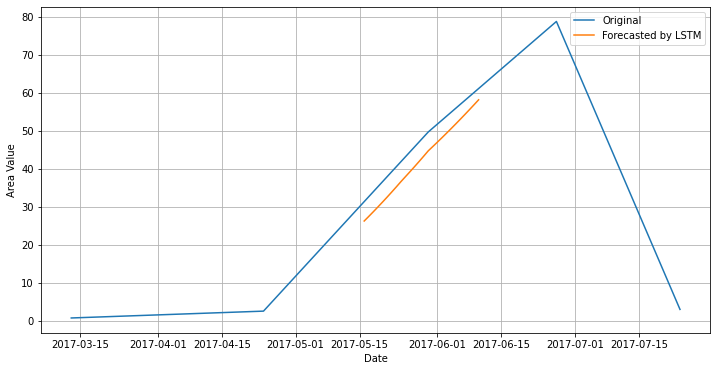

R square: 0.9984 

Wound: 63
Total number of visit days after interpolation 93
3/3 [==============================] - 0s 1ms/step


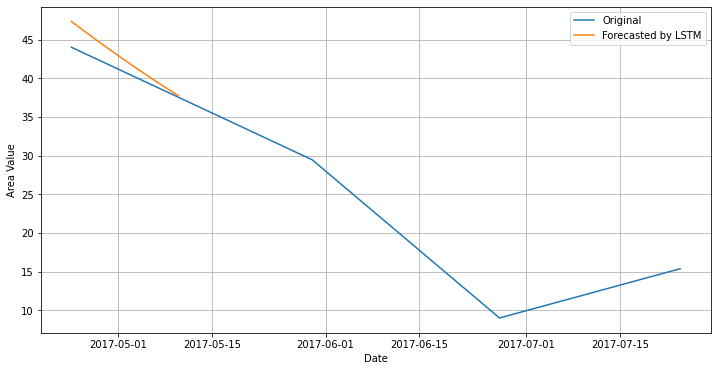

R square: 0.9994 

Wound: 64
Total number of visit days after interpolation 57
2/2 [==============================] - 0s 2ms/step


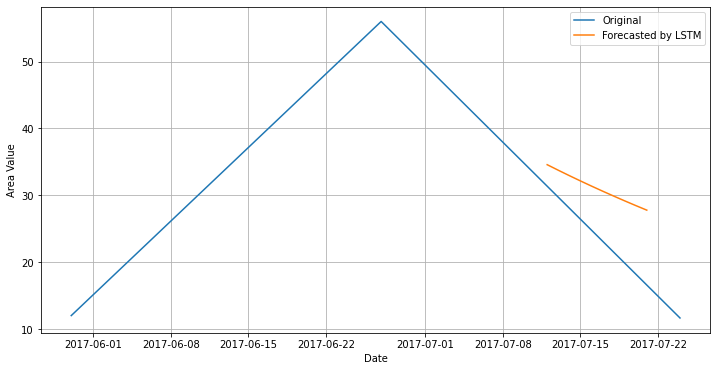

R square: 0.9991 

Wound: 65
Total number of visit days after interpolation 667
17/17 [==============================] - 0s 914us/step


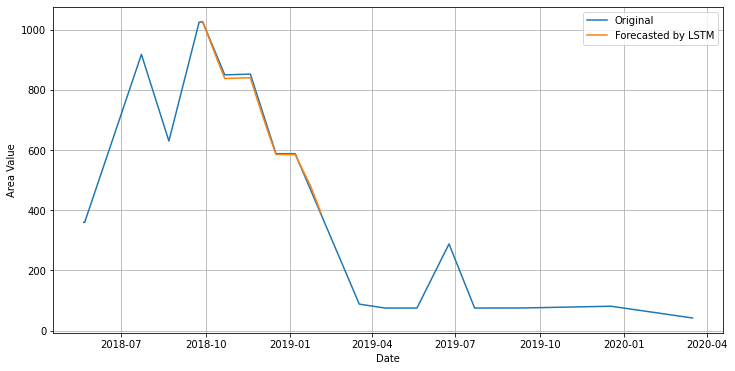

R square: 0.9982 

Wound: 66
Total number of visit days after interpolation 667
17/17 [==============================] - 0s 876us/step


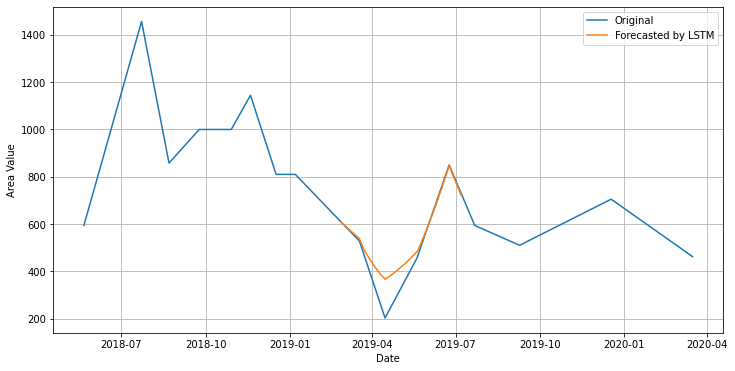

R square: 0.9718 

Wound: 67
Total number of visit days after interpolation 477
12/12 [==============================] - 0s 687us/step


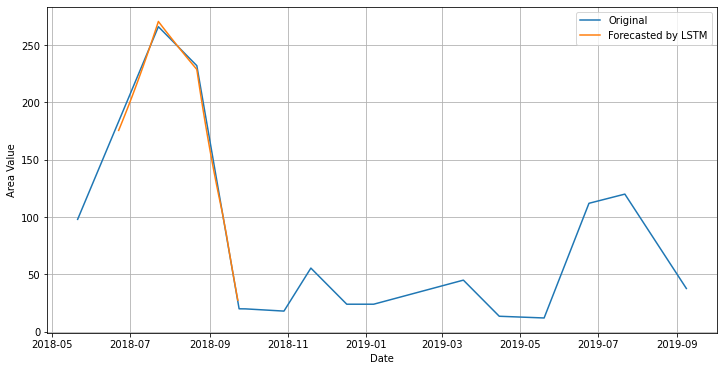

R square: 0.9948 

Wound: 68
Total number of visit days after interpolation 211
6/6 [==============================] - 0s 1ms/step


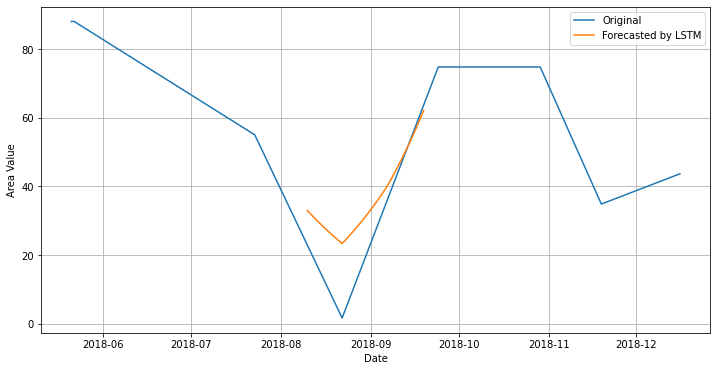

R square: 0.9768 

Wound: 69
Total number of visit days after interpolation 813
21/21 [==============================] - 0s 855us/step


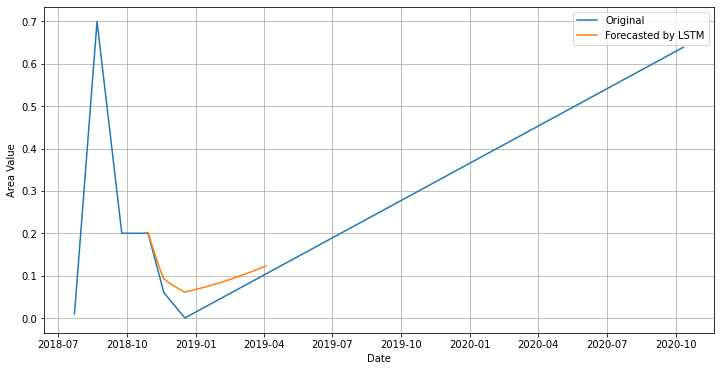

R square: 0.9816 

Wound: 70
Total number of visit days after interpolation 183
5/5 [==============================] - 0s 906us/step


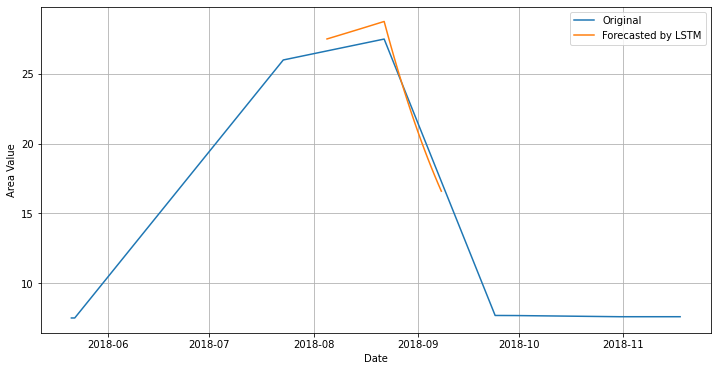

R square: 0.9966 

Wound: 71
Total number of visit days after interpolation 211
6/6 [==============================] - 0s 1ms/step


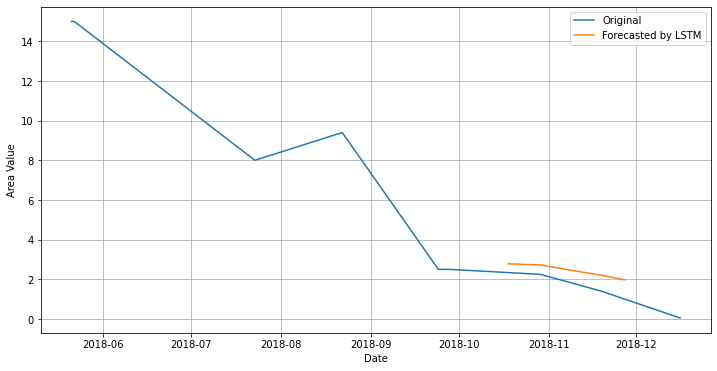

R square: 0.9997 

Wound: 72
Total number of visit days after interpolation 91
3/3 [==============================] - 0s 844us/step


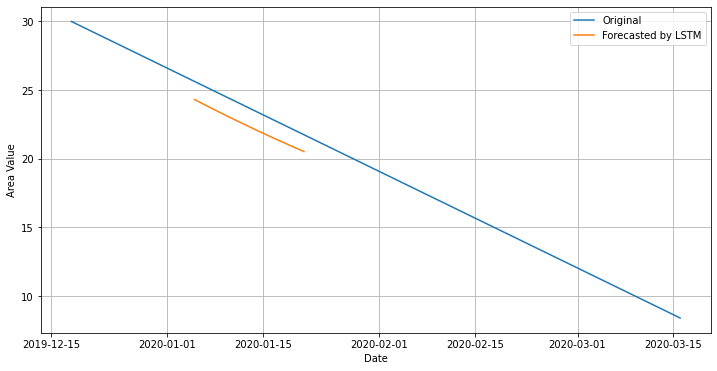

R square: 0.9994 

Wound: 73
Total number of visit days after interpolation 91
3/3 [==============================] - 0s 936us/step


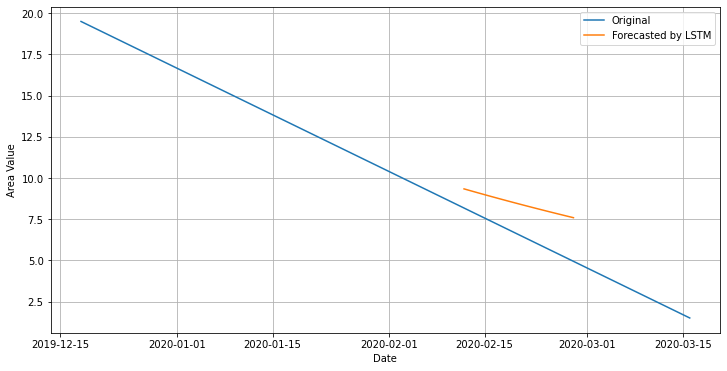

R square: 0.9995 

Wound: 74
Total number of visit days after interpolation 91
3/3 [==============================] - 0s 1ms/step


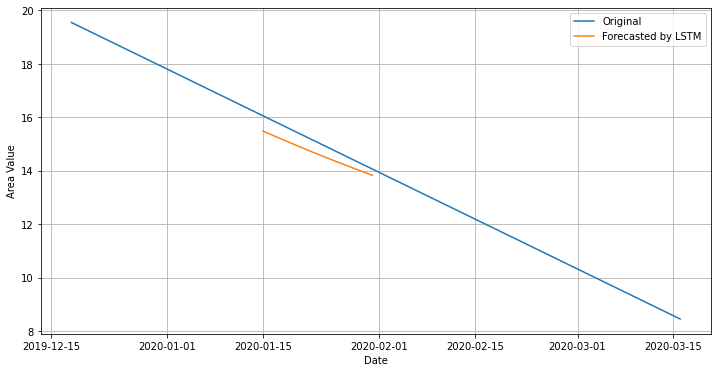

R square: 0.9994 

Wound: 75
Wound: 76
Total number of visit days after interpolation 184
5/5 [==============================] - 0s 863us/step


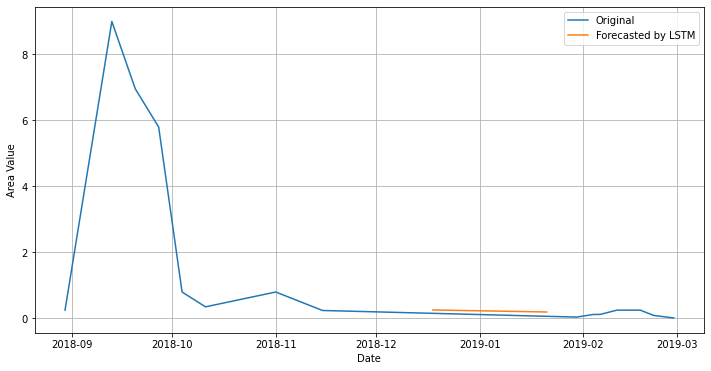

R square: 1.0 

Wound: 77
Total number of visit days after interpolation 24
1/1 [==============================] - 0s 9ms/step


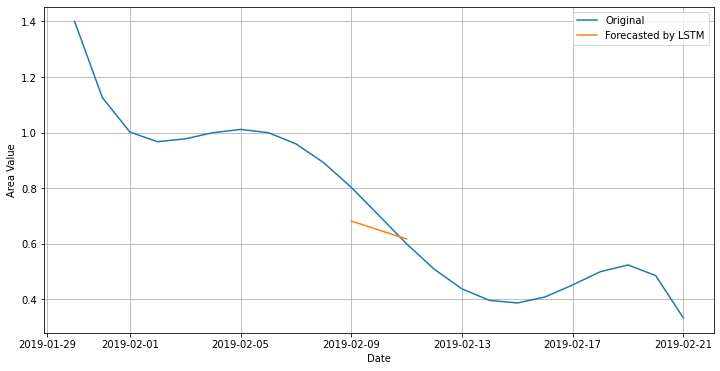

R square: 0.9994 

Wound: 78
Total number of visit days after interpolation 19
1/1 [==============================] - 0s 9ms/step


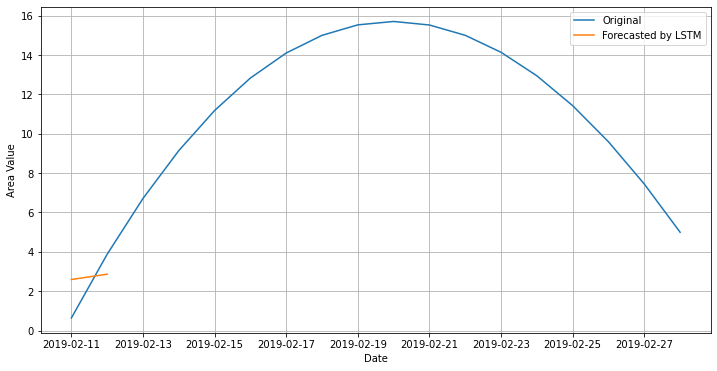

R square: 1.0 

Wound: 79
Wound: 80
Total number of visit days after interpolation 77
2/2 [==============================] - 0s 1ms/step


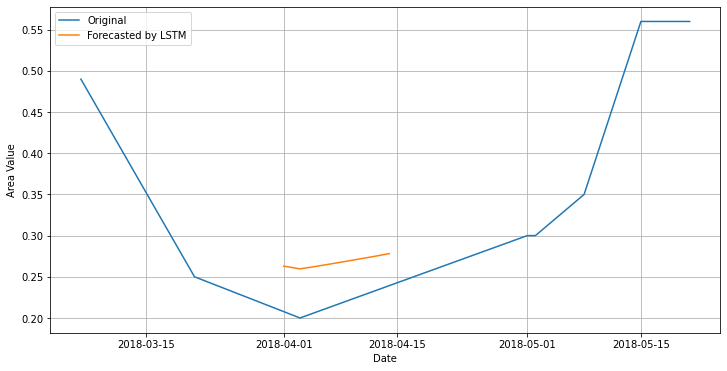

R square: 0.9685 

Wound: 81
Total number of visit days after interpolation 77
2/2 [==============================] - 0s 1ms/step


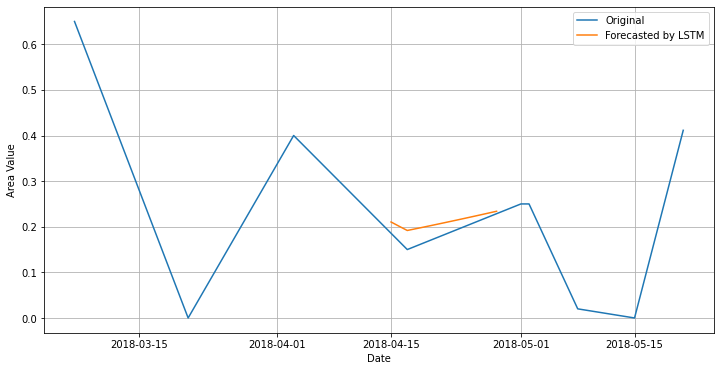

R square: 0.8972 

Wound: 82
Total number of visit days after interpolation 290
8/8 [==============================] - 0s 920us/step


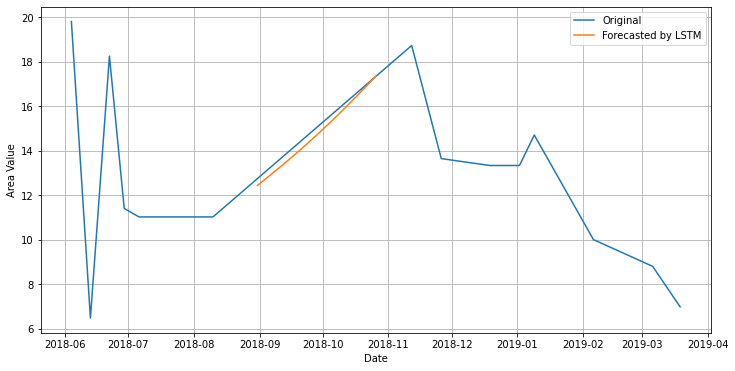

R square: 0.9982 

Wound: 83
Total number of visit days after interpolation 33
1/1 [==============================] - 0s 9ms/step


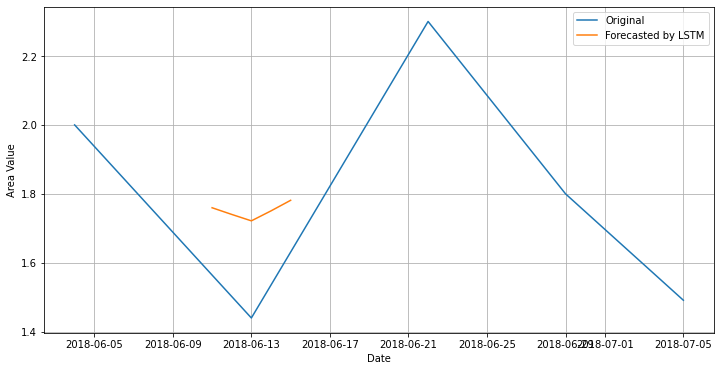

R square: 0.4254 

Wound: 84
Total number of visit days after interpolation 41
1/1 [==============================] - 0s 8ms/step


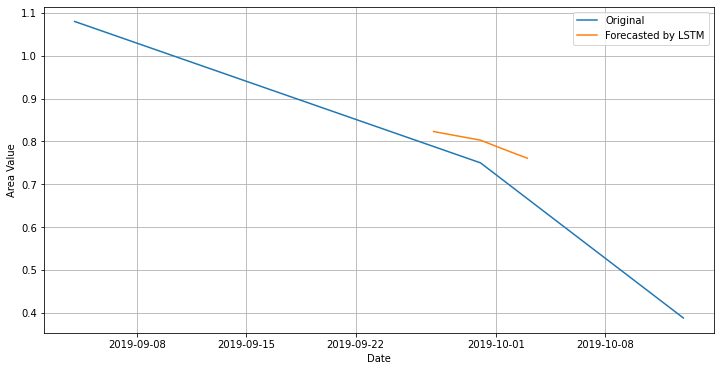

R square: 0.9925 

Wound: 85
Total number of visit days after interpolation 41
1/1 [==============================] - 0s 8ms/step


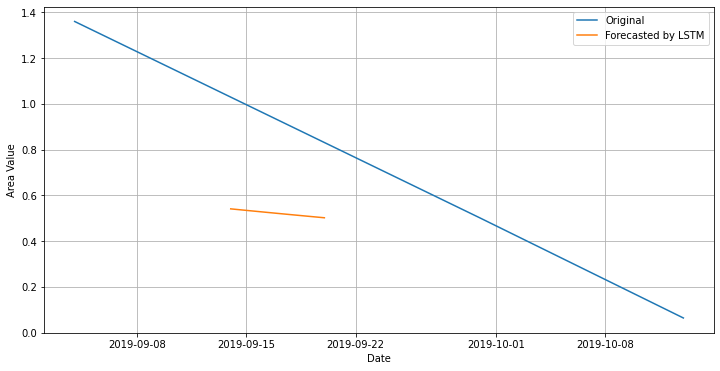

R square: 0.9999 

Wound: 86
Total number of visit days after interpolation 1464
37/37 [==============================] - 0s 747us/step


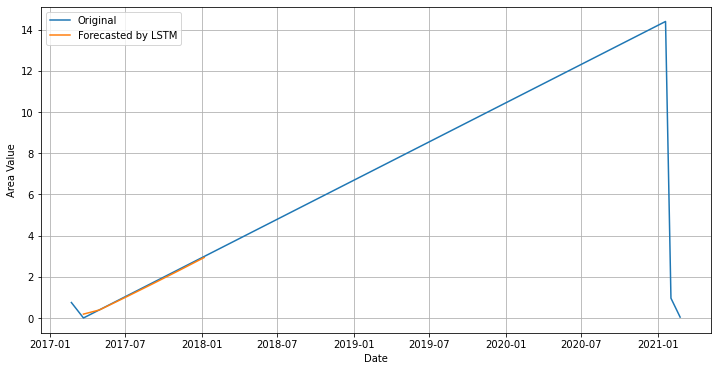

R square: 0.9981 

Wound: 87
Total number of visit days after interpolation 51
2/2 [==============================] - 0s 2ms/step


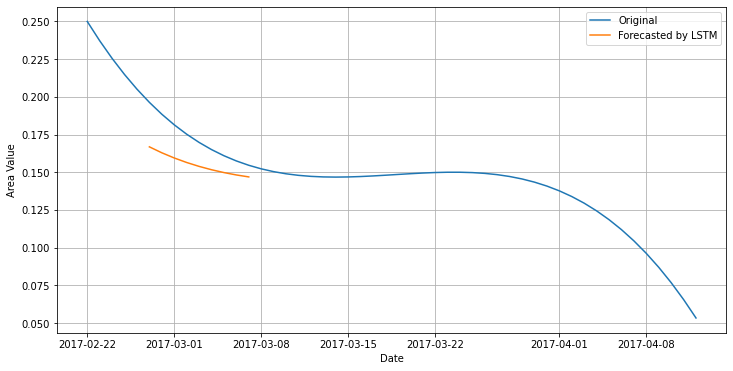

R square: 1.0 

Wound: 88
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


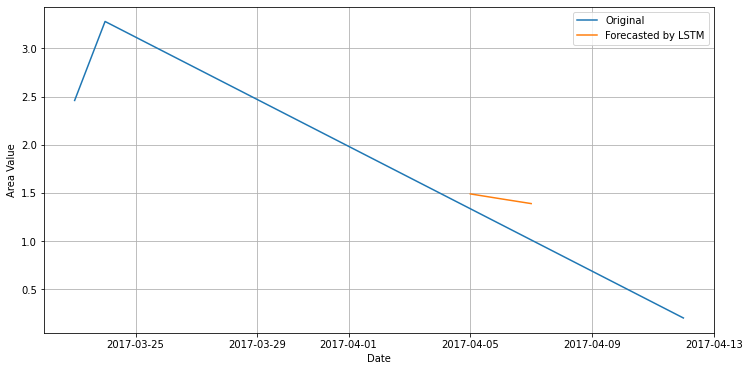

R square: 1.0 

Wound: 89
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


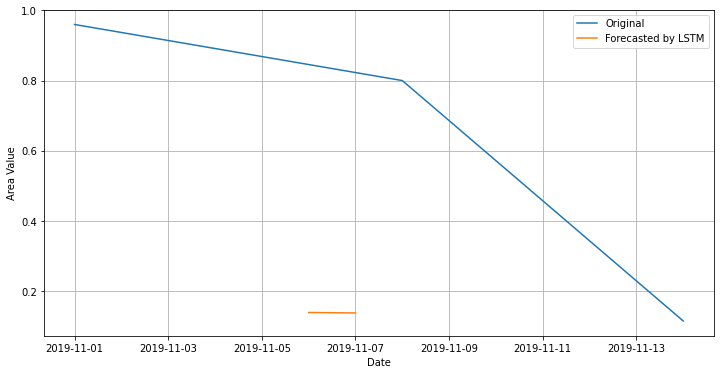

R square: 1.0 

Wound: 90
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 11ms/step


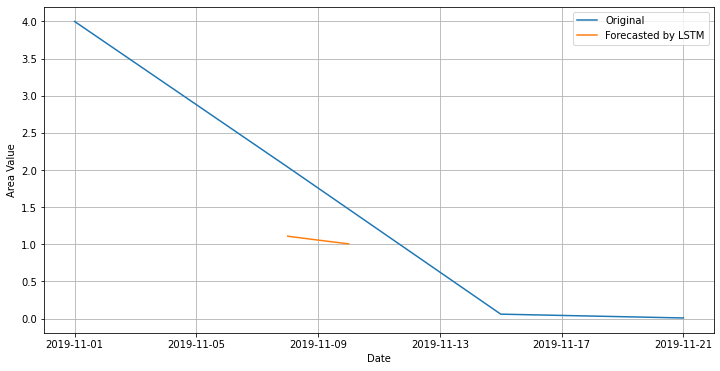

R square: 0.9999 

Wound: 91
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 10ms/step


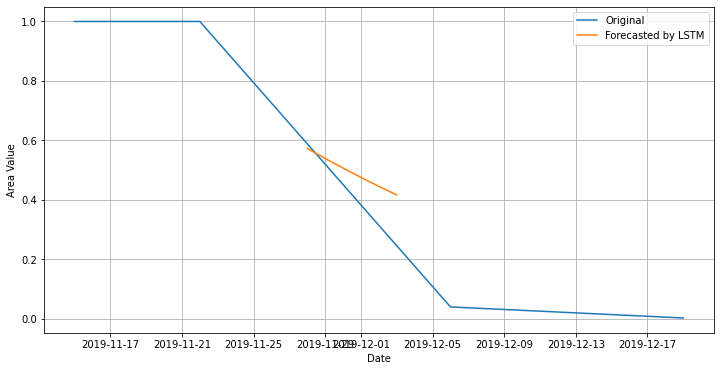

R square: 0.9993 

Wound: 92
Total number of visit days after interpolation 190
5/5 [==============================] - 0s 1ms/step


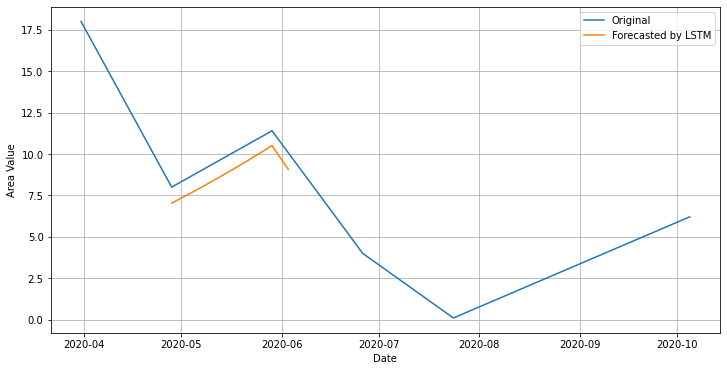

R square: 0.9809 

Wound: 93
Wound: 94
Wound: 95
Total number of visit days after interpolation 415
11/11 [==============================] - 0s 1ms/step


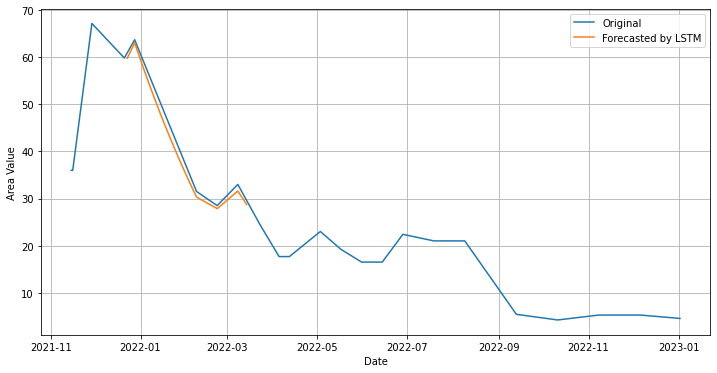

R square: 0.9986 

Wound: 96
Total number of visit days after interpolation 29
1/1 [==============================] - 0s 9ms/step


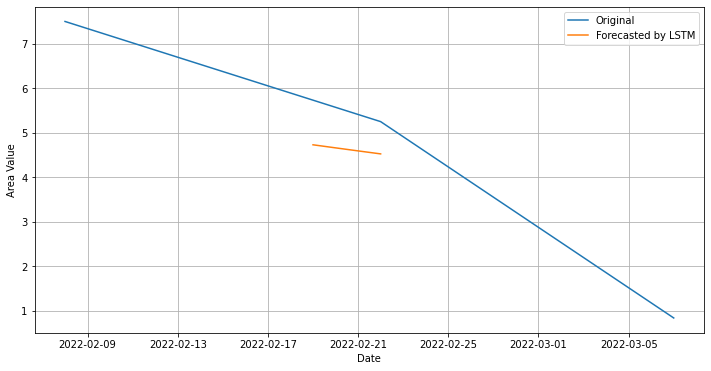

R square: 0.9581 

Wound: 97
Total number of visit days after interpolation 50
2/2 [==============================] - 0s 1ms/step


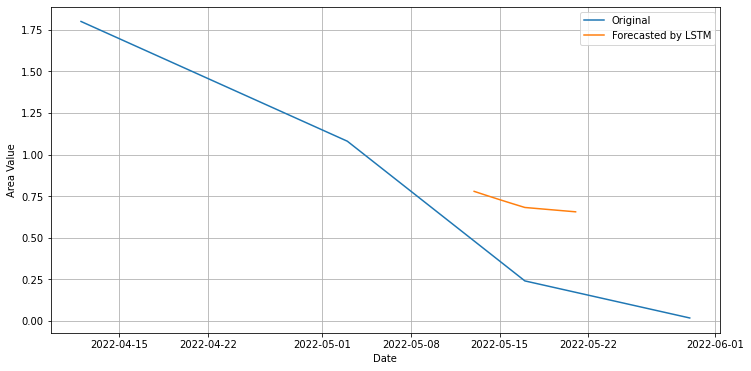

R square: 0.9883 

Wound: 98
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


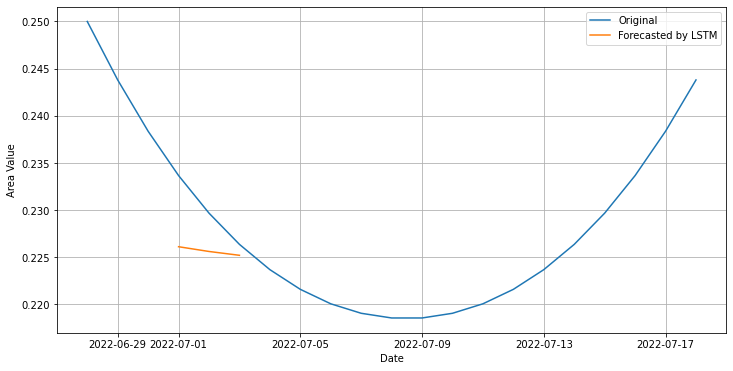

R square: 1.0 

Wound: 99
Total number of visit days after interpolation 85
3/3 [==============================] - 0s 1ms/step


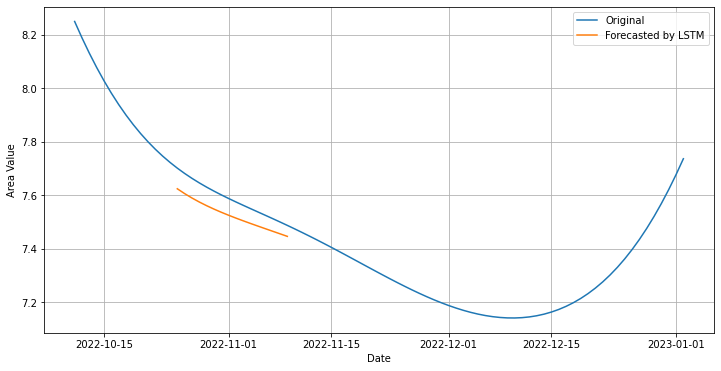

R square: 0.9978 

Wound: 100
Total number of visit days after interpolation 153
4/4 [==============================] - 0s 984us/step


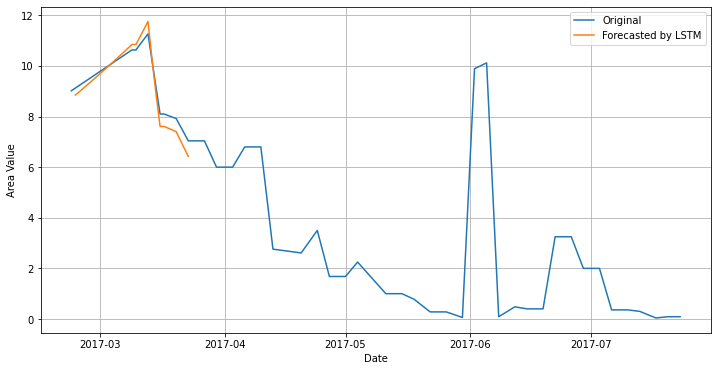

R square: 0.9113 

Wound: 101
Total number of visit days after interpolation 1129
29/29 [==============================] - 0s 744us/step


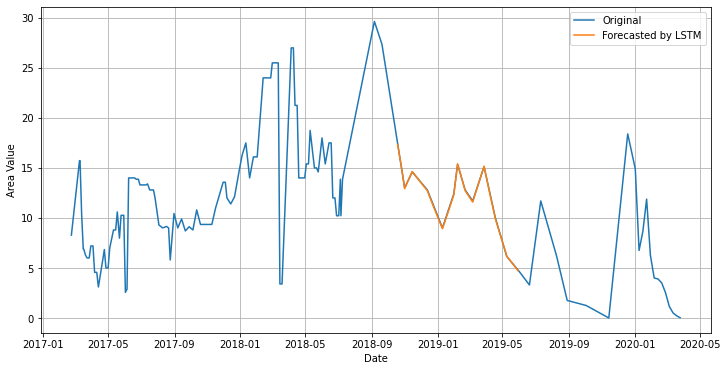

R square: 0.996 

Wound: 102
Total number of visit days after interpolation 1026
26/26 [==============================] - 0s 649us/step


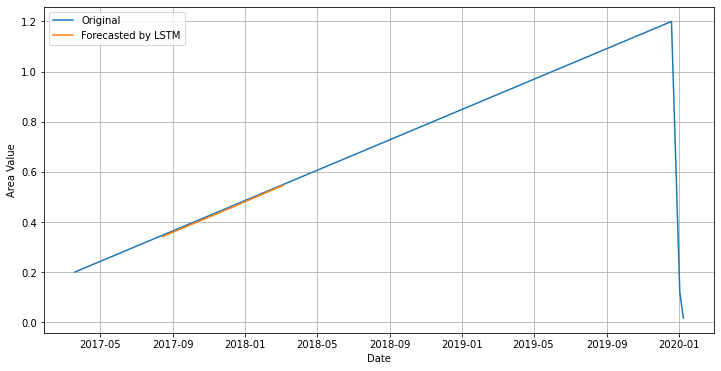

R square: 0.9999 

Wound: 103
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 9ms/step


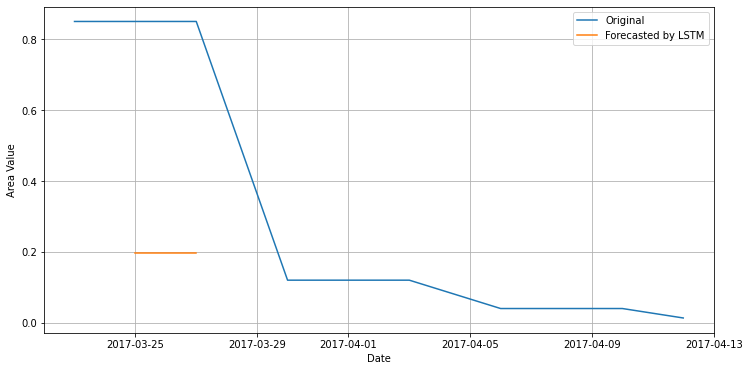

R square: nan 

Wound: 104
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


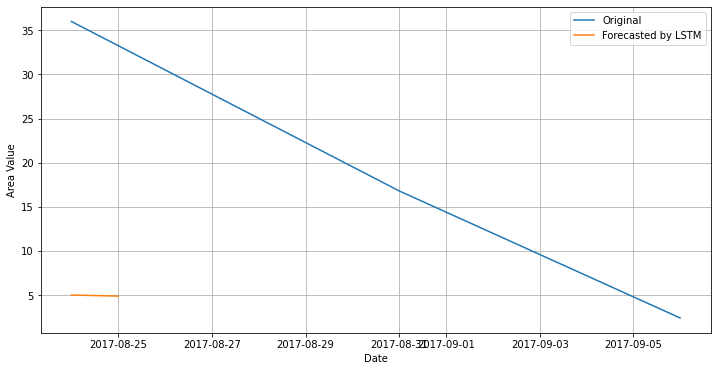

R square: 1.0 

Wound: 105
Total number of visit days after interpolation 393
10/10 [==============================] - 0s 862us/step


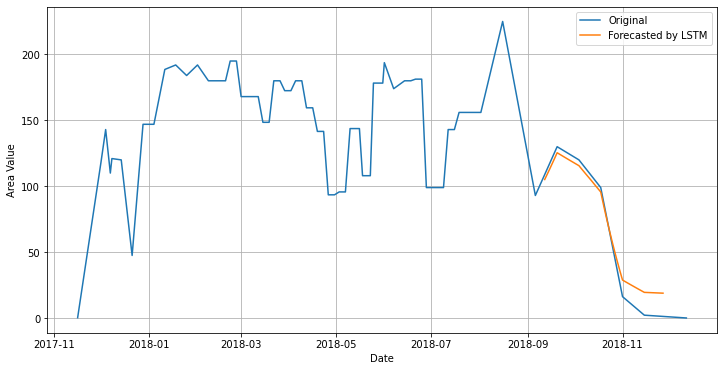

R square: 0.9992 

Wound: 106
Total number of visit days after interpolation 232
6/6 [==============================] - 0s 834us/step


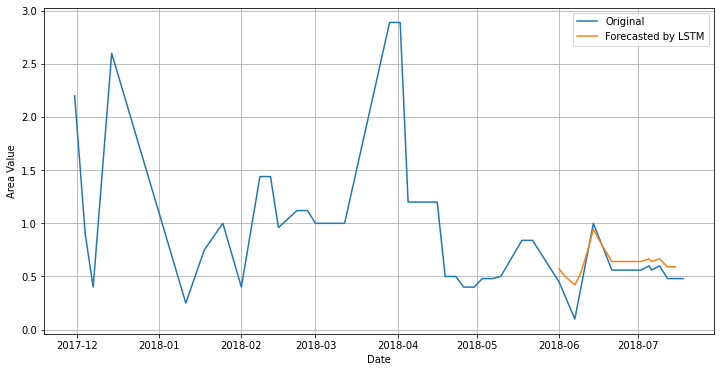

R square: 0.8795 

Wound: 107
Total number of visit days after interpolation 78
2/2 [==============================] - 0s 1ms/step


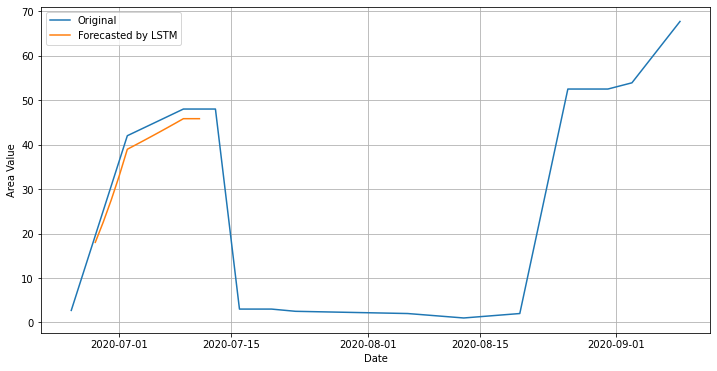

R square: 0.9701 

Wound: 108
Total number of visit days after interpolation 71
2/2 [==============================] - 0s 2ms/step


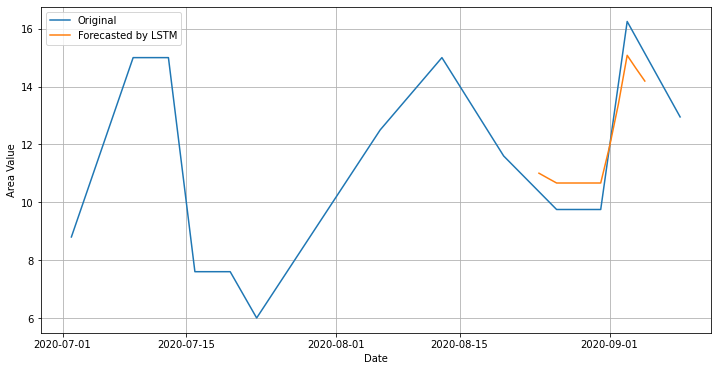

R square: 0.823 

Wound: 109
Total number of visit days after interpolation 28
1/1 [==============================] - 0s 9ms/step


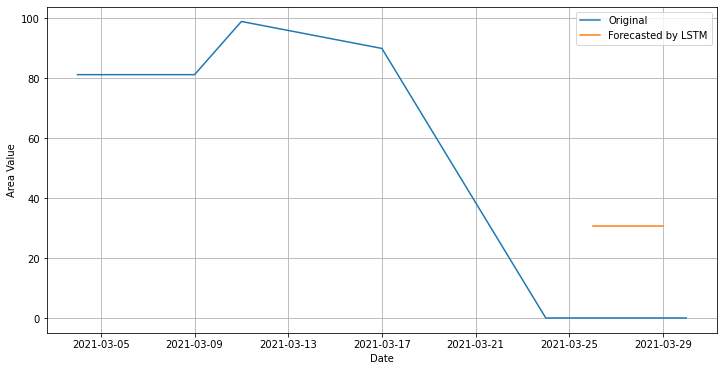

R square: nan 

Wound: 110
Total number of visit days after interpolation 70
2/2 [==============================] - 0s 1ms/step


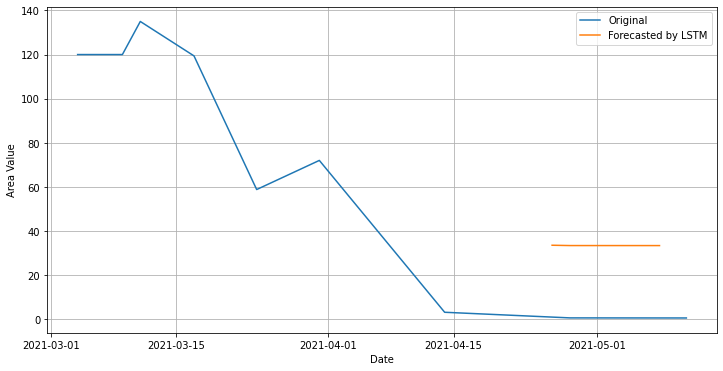

R square: 0.8381 

Wound: 111
Total number of visit days after interpolation 444
12/12 [==============================] - 0s 892us/step


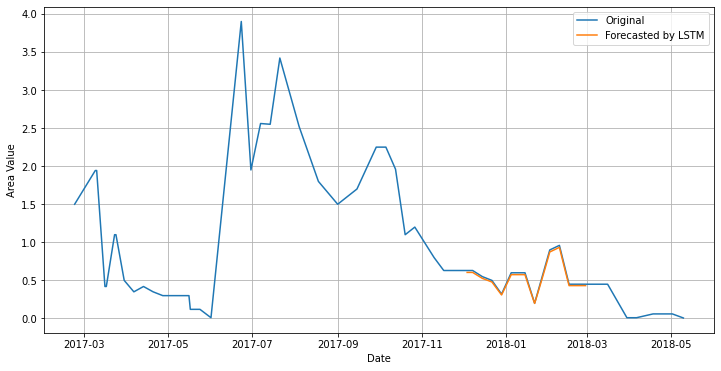

R square: 0.9524 

Wound: 112
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 16ms/step


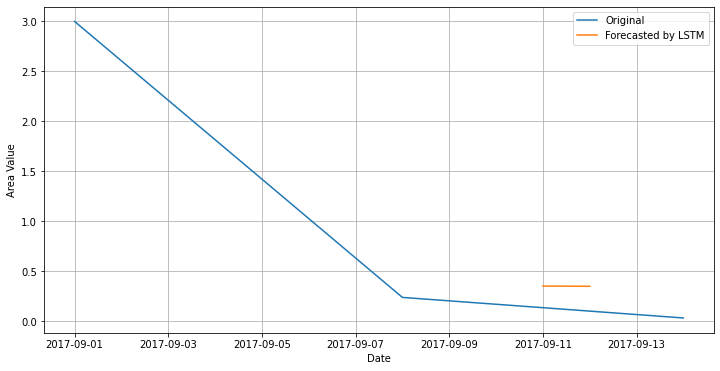

R square: 1.0 

Wound: 113
Total number of visit days after interpolation 41
1/1 [==============================] - 0s 9ms/step


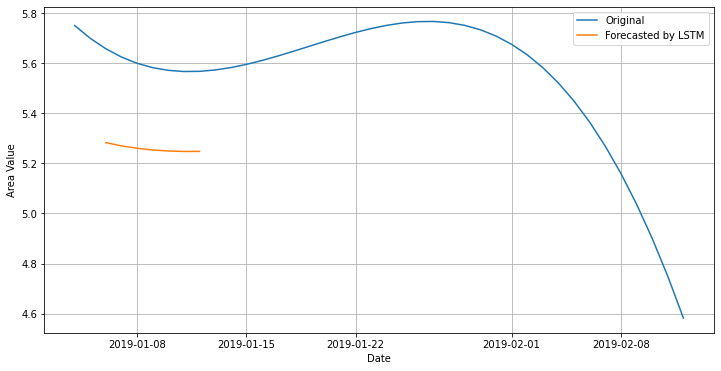

R square: 0.9676 

Wound: 114
Total number of visit days after interpolation 37
1/1 [==============================] - 0s 9ms/step


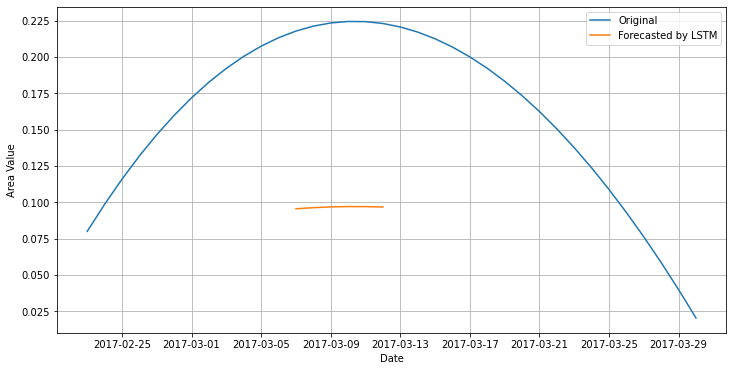

R square: 0.2705 

Wound: 115
Total number of visit days after interpolation 43
2/2 [==============================] - 0s 2ms/step


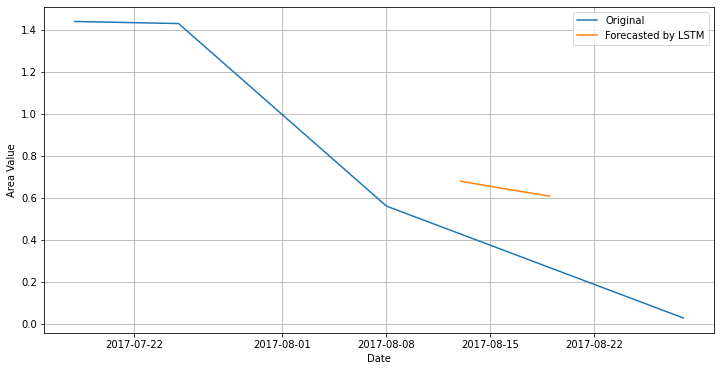

R square: 0.9999 

Wound: 116
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


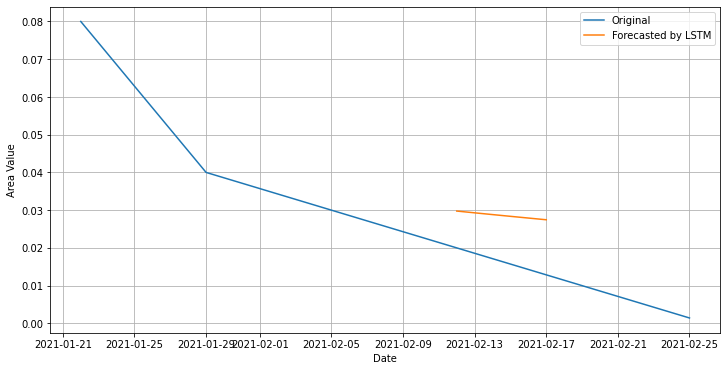

R square: 1.0 

Wound: 117
Total number of visit days after interpolation 91
3/3 [==============================] - 0s 867us/step


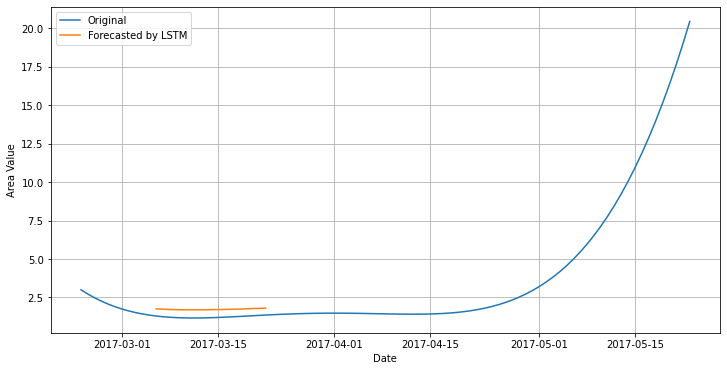

R square: 0.9026 

Wound: 118
Total number of visit days after interpolation 30
1/1 [==============================] - 0s 9ms/step


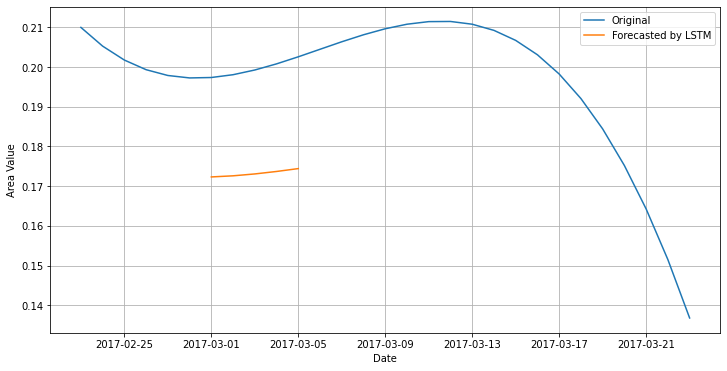

R square: 0.9941 

Wound: 119
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


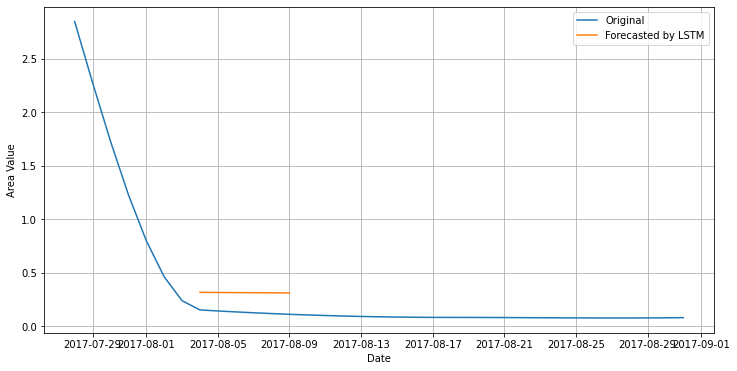

R square: 1.0 

Wound: 120
Total number of visit days after interpolation 22
1/1 [==============================] - 0s 8ms/step


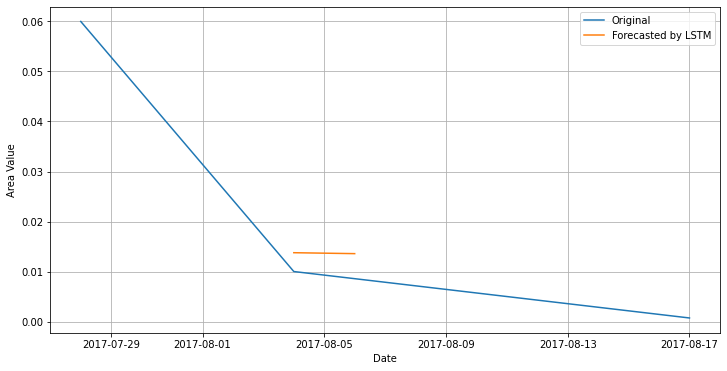

R square: 1.0 

Wound: 121
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 9ms/step


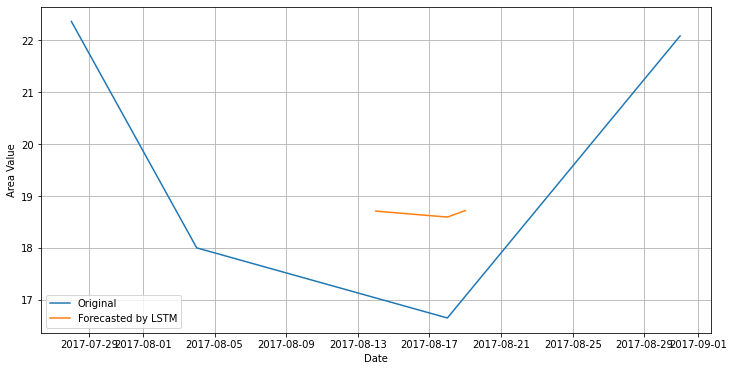

R square: 0.2167 

Wound: 122
Total number of visit days after interpolation 294
8/8 [==============================] - 0s 1ms/step


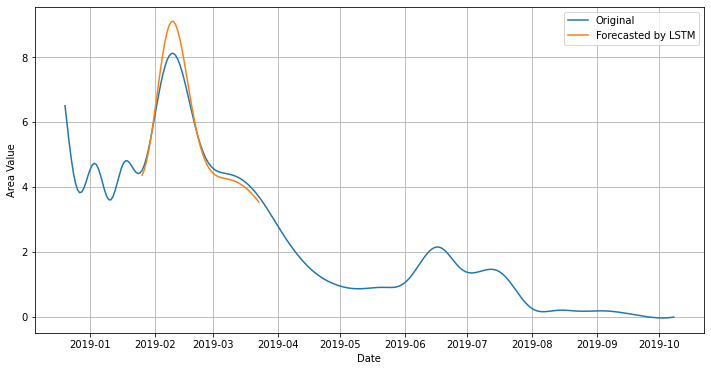

R square: 0.9795 

Wound: 123
Total number of visit days after interpolation 93
3/3 [==============================] - 0s 1ms/step


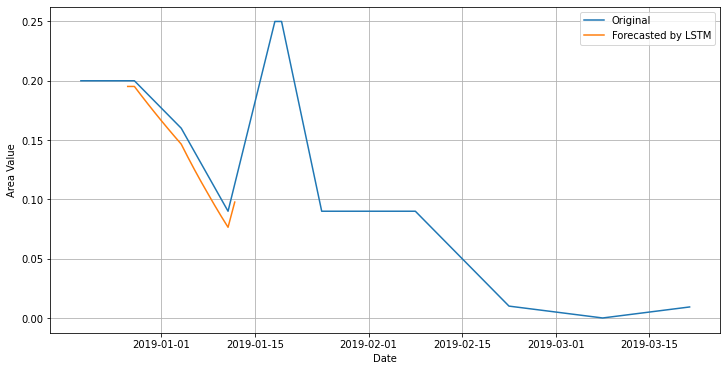

R square: 0.9306 

Wound: 124
Total number of visit days after interpolation 162
5/5 [==============================] - 0s 770us/step


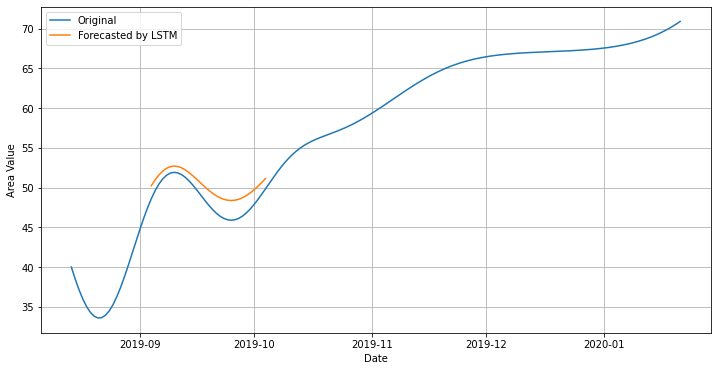

R square: 0.9396 

Wound: 125
Total number of visit days after interpolation 50
2/2 [==============================] - 0s 1ms/step


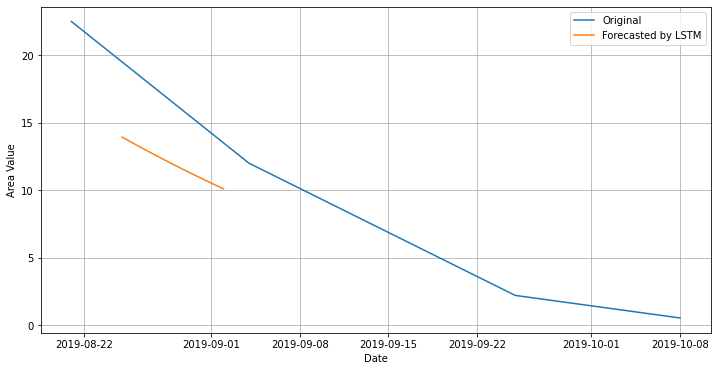

R square: 0.9992 

Wound: 126
Total number of visit days after interpolation 36
1/1 [==============================] - 0s 8ms/step


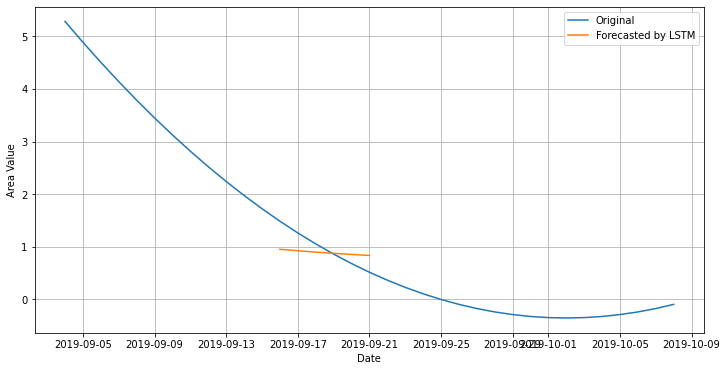

R square: 0.9999 

Wound: 127
Total number of visit days after interpolation 50
2/2 [==============================] - 0s 1ms/step


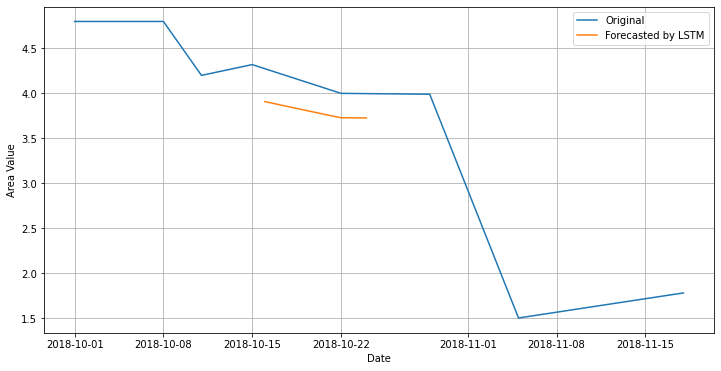

R square: 0.9766 

Wound: 128
Total number of visit days after interpolation 15
1/1 [==============================] - 0s 9ms/step


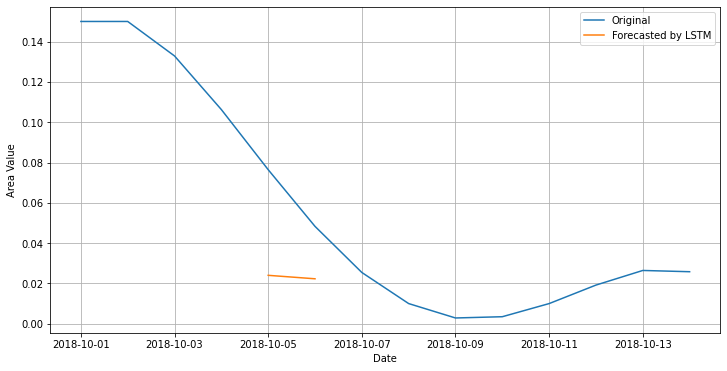

R square: 1.0 

Wound: 129
Total number of visit days after interpolation 86


KeyboardInterrupt: 

In [40]:
list_wounds=df_for["Wound"].unique()

result_df=pd.DataFrame(index=np.arange(len(list_wounds)))

result_df["Wound"]=np.nan
result_df["Gender"]=np.nan
result_df["Race"]=np.nan
result_df["Ethinicity"]=np.nan
result_df["RMSE"]=np.nan
result_df["MASE"]=np.nan
result_df["R-squared"]=np.nan
    

for i in range(0,len(list_wounds)):
#     if i>4:
#         break
    print("Wound:",i+1)
    wound=list_wounds[i]
    df_1=df_for.query("Wound==@wound")
    #display(df_1)
    df=df_1[["Date","Area"]]
    
    if df.shape[0]>9: #and df.shape[0]<1200:
    
    #test,train,df=make_input_for_lstm(df)


        result_df["Wound"][i]=int(df_1["Wound"].unique()[0])
        result_df["Gender"][i]=str(df_1["Gender"].unique()[0])
        result_df["Race"][i]=str(df_1["Race"].unique()[0])
        result_df["Ethinicity"][i]=str(df_1["Ethinicity"].unique()[0])


        rmse, mase, r_square=model_LSTM(df)
        result_df["RMSE"][i]=rmse
        result_df["MASE"][i]=mase
        result_df["R-squared"][i]=r_square
        print("R square:",round(r_square,4),"\n")

result_df["Wound"]=result_df["Wound"].astype(int)

In [12]:
all_values

NameError: name 'all_values' is not defined

In [44]:
i

14917

In [45]:
len(list_wounds)

14918

In [46]:
result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
14913,17877.0,M,White,Non-Hispanic,0.548867,103.129831,0.999979
14914,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14915,17880.0,F,White,Non-Hispanic,0.029260,78.318121,1.000000
14916,17881.0,M,White,Non-Hispanic,1.139973,635.507028,NaN


In [47]:
result_df=result_df.dropna(how='all')
result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
9392,11677.0,F,Black,Non-Hispanic,0.189189,4.303281,1.000000
9393,11678.0,F,Black,Non-Hispanic,0.153680,5.508080,1.000000
9394,11679.0,M,White,Non-Hispanic,2.389204,1236.377730,0.998968
9395,11680.0,F,White,Non-Hispanic,2.245477,14.193564,0.250273
9396,11681.0,F,White,Non-Hispanic,0.229235,5.560607,0.916527
...,...,...,...,...,...,...,...
14911,17875.0,F,White,Non-Hispanic,0.050613,11.177851,1.000000
14912,17876.0,F,White,Non-Hispanic,3.071180,312.081733,1.000000
14913,17877.0,M,White,Non-Hispanic,0.548867,103.129831,0.999979
14915,17880.0,F,White,Non-Hispanic,0.029260,78.318121,1.000000


In [48]:
prev_result_df=pd.read_csv("LSTM_result.csv")
prev_result_df=prev_result_df.drop(["Unnamed: 0"],axis=1)
prev_result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,1.0,M,White,Non-Hispanic,4.046803,137.895060,0.806132
1,2.0,M,White,Non-Hispanic,0.462117,18.667442,0.999403
2,3.0,M,White,Non-Hispanic,0.010494,3.583280,NaN
3,5.0,M,White,Non-Hispanic,2.599811,3.294876,1.000000
4,6.0,M,White,Non-Hispanic,0.069997,1.260419,1.000000
...,...,...,...,...,...,...,...
8809,11669.0,M,White,Non-Hispanic,3.178595,8.712161,1.000000
8810,11672.0,M,White,Non-Hispanic,0.000000,NaN,NaN
8811,11673.0,M,White,Non-Hispanic,0.000000,NaN,NaN
8812,11674.0,M,White,Non-Hispanic,0.081340,6.818337,0.975878


In [49]:
prev_result_df=prev_result_df.dropna(how='all')
prev_result_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,1.0,M,White,Non-Hispanic,4.046803,137.895060,0.806132
1,2.0,M,White,Non-Hispanic,0.462117,18.667442,0.999403
2,3.0,M,White,Non-Hispanic,0.010494,3.583280,NaN
3,5.0,M,White,Non-Hispanic,2.599811,3.294876,1.000000
4,6.0,M,White,Non-Hispanic,0.069997,1.260419,1.000000
...,...,...,...,...,...,...,...
8809,11669.0,M,White,Non-Hispanic,3.178595,8.712161,1.000000
8810,11672.0,M,White,Non-Hispanic,0.000000,NaN,NaN
8811,11673.0,M,White,Non-Hispanic,0.000000,NaN,NaN
8812,11674.0,M,White,Non-Hispanic,0.081340,6.818337,0.975878


In [50]:
new_df=pd.concat([prev_result_df,result_df],axis=0)
new_df

,Wound,Gender,Race,Ethinicity,RMSE,MASE,R-squared
0,1.0,M,White,Non-Hispanic,4.046803,137.895060,0.806132
1,2.0,M,White,Non-Hispanic,0.462117,18.667442,0.999403
2,3.0,M,White,Non-Hispanic,0.010494,3.583280,NaN
3,5.0,M,White,Non-Hispanic,2.599811,3.294876,1.000000
4,6.0,M,White,Non-Hispanic,0.069997,1.260419,1.000000
...,...,...,...,...,...,...,...
14911,17875.0,F,White,Non-Hispanic,0.050613,11.177851,1.000000
14912,17876.0,F,White,Non-Hispanic,3.071180,312.081733,1.000000
14913,17877.0,M,White,Non-Hispanic,0.548867,103.129831,0.999979
14915,17880.0,F,White,Non-Hispanic,0.029260,78.318121,1.000000


In [51]:
new_df.to_csv("LSTM_result.csv")

In [356]:
## LSTM model is unable to predict if there is 8 or less visit days in total

In [42]:
# #LSTM

# mase_value_all=0
# mape_value_all=0
# me_value_all=0
# mae_value_all=0
# mpe_value_all=0
# rmse_value_all=0
# corr_value_all=0
# #minmax_value_all=0
# r_square_value_all=0


# dff=df
# dff['Date'] = pd.to_datetime(dff['Date'])
# dff.set_axis(dff['Date'])#, inplace=True)


# area_data = dff['Area'].values
# area_data = area_data.reshape((-1,1))

# split_percent = 0.80
# split = int(split_percent*len(area_data))

# area_train = area_data[:split]
# area_test = area_data[split:]

# date_train = dff['Date'][:split]
# date_test = dff['Date'][split:]

# look_back = int((len(date_test)-1)/2)
# look_back=1

# train_generator = TimeseriesGenerator(area_train, area_train, length=look_back, batch_size=20)     
# test_generator = TimeseriesGenerator(area_test, area_test, length=look_back, batch_size=1)


# model = Sequential()
# model.add(
#     LSTM(50,
#         activation='relu',
#         input_shape=(look_back,1))
# )
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# num_epochs = 25
# model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

# prediction = model.predict_generator(test_generator)

# area_train = area_train.reshape((-1))
# area_test = area_test.reshape((-1))
# prediction = prediction.reshape((-1))

# print("Length of prediction: ",len(prediction))
# print("Length of test_set:", len(area_test))

# area_test_2=area_test[:len(prediction)]

# #Finding the accuracy measures of the model

# mape = np.mean(np.abs(prediction - area_test_2)/np.abs(area_test_2)) #MAPE
# me = np.mean(prediction - area_test_2)             # ME
# mae = np.mean(np.abs(prediction - area_test_2))    # MAE
# mpe = np.mean((prediction - area_test_2)/area_test_2)   # MPE
# rmse = np.mean((prediction - area_test_2)**2)**.5  # RMSE

# #actual_without_nan=area_test_2.dropna()
# corr= np.corrcoef(prediction,area_test_2)[0,1]
# r_square= corr**2  #r_square

# n = area_train.shape[0]
# #print("N",n)
# d = np.abs(  np.diff(area_train) ).sum()/(n-1)
# errors = np.abs(area_test_2 - prediction )
# mase=errors.mean()/d

# print("For Patient number "+str(int(i/2+1)))
# print("MASE:",mase)
# print("MAPE:",mape)
# print("ME:",me)
# print("MAE:",mae)
# print("MPE:",mpe)
# print("RMSE:",rmse)
# print("CORR:",corr)
# print("R-SQUARE",r_square)

# trace1 = go.Scatter(
#     x = date_train,
#     y = area_train,
#     mode = 'lines',
#     name = 'Train Data'
# )
# trace2 = go.Scatter(
#     x = date_test,
#     y = prediction,
#     mode = 'lines',
#     name = 'Prediction Data'
# )
# trace3 = go.Scatter(
#     x = date_test,
#     y = area_test,
#     mode='lines',
#     name = 'Test Data'
# )
# layout = go.Layout(
#     title = "Wound Area Forecasting for Patient number "+str(int(i/2+1)),
#     xaxis = {'title' : "Date"},
#     yaxis = {'title' : "Area"}
# )
# fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
# fig.show()

# area_data = area_data.reshape((-1))

# def predict(num_prediction, model):
#     prediction_list = area_data[-look_back:]

#     for _ in range(num_prediction):
#         x = prediction_list[-look_back:]
#         x = x.reshape((1, look_back, 1))
#         out = model.predict(x)[0][0]
#         prediction_list = np.append(prediction_list, out)
#     prediction_list = prediction_list[look_back-1:]

#     return prediction_list

# def predict_dates(num_prediction):
#     last_date = dff['Date'].values[-1]
#     prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
#     return prediction_dates

# num_prediction = 14
# forecast = predict(num_prediction, model)
# forecast_dates = predict_dates(num_prediction)

# dff_1=pd.DataFrame({'Date':forecast_dates,'Area':forecast})
# dff_1